In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
from arch import arch_model
warnings.filterwarnings("ignore")

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
import yfinance as yf 


In [4]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd.iloc[-1,1]=yf.download(tickers='USDTRY=X',interval='1m')["Adj Close"][-1]
usd

[*********************100%%**********************]  1 of 1 completed


,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.326300
1,02-02-2006,1.324100
2,03-02-2006,1.327700
3,06-02-2006,1.325700
4,07-02-2006,1.329600
...,...,...
4668,25-12-2023,29.186900
4669,26-12-2023,29.263400
4670,27-12-2023,29.317400
4671,28-12-2023,29.390300


In [5]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114


In [6]:
enf=evds.get_data(["TP.FE.OKTG01"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FE_OKTG01
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11


In [217]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [218]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04
212,2023-10,1749.11


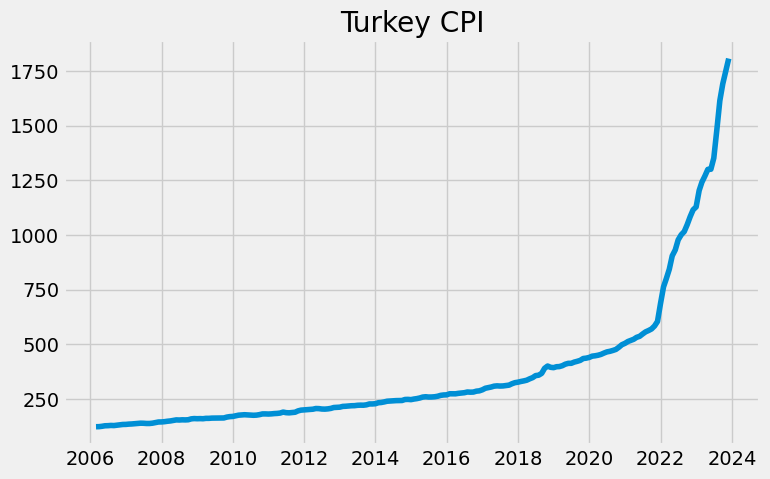

In [219]:
dates=pd.date_range(start="2006-02-28",periods=len(enf) , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [10]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114


In [11]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28',periods=len(money), freq='1M'))
money

,Para Arzi
2006-02-28,2.423895
2006-03-31,2.494857
2006-04-30,2.521919
2006-05-31,2.751947
2006-06-30,2.791388
...,...
2023-08-31,120.253200
2023-09-30,123.493100
2023-10-31,127.637895
2023-11-30,130.504631


In [12]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-08-31,123.434020
2023-09-30,126.661059
2023-10-31,130.934676
2023-11-30,134.161244


In [13]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",periods=len(issizlik),freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-06-30,9.5
2023-07-31,9.3
2023-08-31,9.1
2023-09-30,9.0


In [14]:
import yfinance as yf
df14=yf.download("BZ=F")["Close"]
df14=pd.DataFrame(df14)
df14.columns=["Brent"]
df14=df14.resample('M').mean()
df14

[*********************100%%**********************]  1 of 1 completed


,Brent
Date,
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2023-08-31,85.104348
2023-09-30,92.766499
2023-10-31,88.704091


In [15]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10
212,2023-10,1.047935e+10
213,2023-11,1.078661e+10


In [16]:
dates=pd.date_range('2006-02-01',periods=len(kredi) , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
210,2023-8,99.238055
211,2023-9,102.582870
212,2023-10,104.793503
213,2023-11,107.866144


In [17]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28',periods=len(df3) , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,107.866144


In [18]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
210,2023-8,23.50
211,2023-9,31.00
212,2023-10,33.00
213,2023-11,41.09


In [19]:
dates=pd.date_range('2006-02-28',periods=len(pfaiz) , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00


In [20]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del kfaiz["Tarih"]
del kfaiz["YEARWEEK"]
kfaiz=kfaiz.set_index(pd.date_range(start="2006-02-01",periods=len(kfaiz),freq="1W"))
kfaiz=kfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])
kfaiz.columns=["Kredi Faizi"]
kfaiz

,Kredi Faizi
2006-02-28,17.02
2006-03-31,16.88
2006-04-30,15.84
2006-05-31,16.60
2006-06-30,20.35
...,...
2023-08-31,45.29
2023-09-30,57.56
2023-10-31,58.43
2023-11-30,58.61


In [21]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",periods=len(perakende1),freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-06-30,180.070938,186.192371,179.437348
2023-07-31,191.652101,194.142558,184.796934
2023-08-31,185.107822,183.341634,176.289202
2023-09-30,184.891859,183.368030,175.221191


In [22]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",periods=len(motorin),freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-07-31,29.480000
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.900000


In [23]:
sanayi=pd.read_excel("./sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-06-30,148.238298
2023-07-31,147.640395
2023-08-31,146.465496
2023-09-30,146.342705


In [24]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="03-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
#mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2024-01-01",freq="1M"))
del mfaiz["YEARWEEK"]
del mfaiz["Tarih"]
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-03",periods=len(mfaiz),freq="W"))
mfaiz=mfaiz.resample('M').apply(lambda x : x[-2:].iloc[-1])

mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.70
2006-03-31,14.84
2006-04-30,14.87
2006-05-31,14.84
2006-06-30,15.57
...,...
2023-08-31,30.76
2023-09-30,42.74
2023-10-31,41.72
2023-11-30,46.07


In [25]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",periods=len(enf_belirsizlik),freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-08-31,6.81
2023-09-30,7.30
2023-10-31,5.57
2023-11-30,4.49


In [26]:
borc=evds.get_data(["TP.KB.A09"],startdate="01-01-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2006-01-01",periods=len(borc),freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2006-01-31,2.435600e+08
2006-02-28,2.464270e+08
2006-03-31,2.463600e+08
2006-04-30,2.466640e+08
2006-05-31,2.507320e+08
...,...
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09


In [27]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",periods=len(redk),freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-07-31,81.62
2023-08-31,85.39
2023-09-30,89.35
2023-10-31,89.16


In [28]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",periods=len(redkt),freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-07-31,48.71
2023-08-31,52.42
2023-09-30,55.55
2023-10-31,56.01


In [29]:
gıda=evds.get_data(["TP.FG.J01"],startdate="01-01-2006",frequency=5,enddate="31-12-2023")
del gıda["Tarih"]
gıda=gıda.set_index(pd.date_range(start="2006-01-30",periods=len(gıda),freq="1M"))
gıda.columns=["Gıda"]
gıda

,Gıda
2006-01-31,117.61
2006-02-28,120.44
2006-03-31,122.00
2006-04-30,122.75
2006-05-31,123.63
...,...
2023-07-31,2147.27
2023-08-31,2329.27
2023-09-30,2406.50
2023-10-31,2483.58


In [220]:
data=pd.DataFrame()
data["USD/TL"]=df6["USD/TL"][:-1].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["Borç"]=(borc["Borç"]/1e+08).shift(1)
data["TÜFE"]=df["CPI"]
#data["Gıda"]=gıda["Gıda"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)
data

,USD/TL,ParaArzi,Motorin,Perakende Satış,Sanayi,Kredi,M3,Borç,TÜFE
Tarih,,,,,,,,,
2010-02-28,0.574311,-0.468328,-0.470323,0.935668,2.358713,2.473323,-0.317515,1.774400,1.447693
2010-03-31,0.644001,1.850070,2.622296,1.971218,1.929881,2.894349,1.831928,1.064192,0.583272
2010-04-30,0.478728,1.038067,0.713406,0.918462,1.021775,3.033220,0.969354,0.366513,0.596780
2010-05-31,0.646630,0.240025,-0.856462,0.610769,2.763430,3.592510,0.095471,0.729264,-0.358182
2010-06-30,0.922501,1.537408,-0.175370,-0.094972,0.563442,3.358199,1.609402,-0.769974,-0.561672
...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,15.146856,33.393665,2.986884,-0.403339,5.675617,15.439600,9.689321,9.488824
2023-08-31,10.505114,5.943431,26.763908,-4.603827,-0.795784,1.850455,5.968276,2.618269,9.086793
2023-09-30,5.071342,4.764088,4.843457,-0.605829,-0.083836,2.080815,4.845313,4.384930,4.753114


In [221]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data=data.dropna(axis=0)
data=data[['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','M3','İşsizlik','Politika Faizi','TÜFE']]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,M3,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.80,11.01,3.604096,0.82,3.375162,-0.584687,3.267877,8.85,91.32,95.75,3.413428,9.2,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.54,0.00,-0.850238,0.73,1.804994,0.808574,1.451593,10.75,93.31,96.63,2.079333,9.5,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,16.05,0.00,0.128936,0.80,0.451349,0.193691,0.341852,11.65,93.75,97.25,0.229599,9.5,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.65,0.00,-0.863760,0.73,0.796760,0.478162,0.129671,10.75,98.14,102.98,0.730196,9.7,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.36,0.00,-1.367417,0.80,-0.362357,0.091080,0.468727,10.43,99.40,105.10,-0.093468,9.7,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,7.066073,16.807611,-0.151044,38.78,0.00,1.117934,7.55,-1.017069,2.406884,5.711697,41.98,87.02,51.59,-1.142443,9.5,12.84,3.920498
2023-07-31,11.475241,33.393665,2.986884,44.58,34.00,-0.403339,7.70,15.146856,9.689321,5.675617,29.32,81.62,48.71,15.439600,9.3,17.50,9.488824
2023-08-31,10.505114,26.763908,-4.603827,45.29,0.00,-0.795784,6.81,5.943431,2.618269,1.850455,30.76,85.39,52.42,5.968276,9.1,23.50,9.086793


In [32]:
features=["USD/TL","Motorin","Enflasyon Belirsizliği","ParaArzi","Kredi Faizi","TÜFE"]
train=data[features].iloc[:-3,:]
test=data[features].iloc[-3:,:]


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

In [34]:
test_period = 3 
test_size = test_period   

train_data = data[:-test_size]
test_data = data[-test_size:]

# Bağımsız değişkenleri ve TÜFE'yi ayırın
X_train = train.drop(['TÜFE'], axis=1).values
y_train = train['TÜFE'].values
X_test = test.drop(['TÜFE'], axis=1).values
y_test = test['TÜFE'].values

In [35]:
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
import keras
keras.utils.set_random_seed(1)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(X_train_scaled.shape[1],1)))
model.add(tf.keras.layers.Dense(64,activation='selu'))
model.add(tf.keras.layers.Dense(64,activation='elu'))
model.add(tf.keras.layers.Dense(1))
rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=rms, loss='mean_squared_error')


early_stopping = EarlyStopping(patience=25, restore_best_weights=True)

model.fit(X_train_scaled, y_train_scaled, epochs=500, batch_size=32, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])


Epoch 1/500
4/4 [==============================] - 3s 196ms/step - loss: 4.6707 - val_loss: 0.9604
Epoch 2/500
4/4 [==============================] - 0s 23ms/step - loss: 0.2287 - val_loss: 0.1489
Epoch 3/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0199 - val_loss: 0.0694
Epoch 4/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0128 - val_loss: 0.0647
Epoch 5/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0122 - val_loss: 0.0570
Epoch 6/500
4/4 [==============================] - 0s 26ms/step - loss: 0.0119 - val_loss: 0.0595
Epoch 7/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0113 - val_loss: 0.0486
Epoch 8/500
4/4 [==============================] - 0s 19ms/step - loss: 0.0114 - val_loss: 0.0225
Epoch 9/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0148 - val_loss: 0.0110
Epoch 10/500
4/4 [==============================] - 0s 23ms/step - loss: 0.0642 - val_loss: 0.0166
Epoch 11/500
4/4 [

In [ ]:
'''import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import ParameterGrid

# Verileri ve etiketleri yükleyin (X_train, X_test, y_train, y_test olarak varsayalım)

# Model fonksiyonunu tanımlayın
def create_model(neurons=128, activation='relu', optimizer='adam', epochs=100):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])
    return model


# Grid Search için hiperparametre kombinasyonlarını tanımlayın
param_grid = {
    'neurons': [64, 128],
    'activation': ['relu', 'tanh','selu','sigmoid','elu','gelu','linear'],
    'optimizer': ['adam', 'rmsprop','Adadelta','Adagrad','Adamax','Nadam','Ftrl'],
    'epochs': [500]
}

best_rmse = float('inf')
best_params = None

# Grid Search yapın
for params in ParameterGrid(param_grid):
    model = create_model(neurons=params['neurons'], activation=params['activation'], optimizer=params['optimizer'], epochs=params['epochs'])
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test_scaled, y_pred)
    rmse = np.sqrt(mse)
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# En iyi hiperparametreleri ve sonuçları görüntüleyin
print("En iyi RMSE:", best_rmse)
print("En iyi parametreler:", best_params)'''


'import numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import LSTM, Dense\nfrom sklearn.metrics import make_scorer, mean_squared_error\nfrom sklearn.model_selection import ParameterGrid\n\n# Verileri ve etiketleri yükleyin (X_train, X_test, y_train, y_test olarak varsayalım)\n\n# Model fonksiyonunu tanımlayın\ndef create_model(neurons=128, activation=\'relu\', optimizer=\'adam\', epochs=100):\n    model = Sequential()\n    model.add(LSTM(neurons, activation=activation, input_shape=(X_train.shape[1], 1)))\n    model.add(Dense(1))\n    model.compile(optimizer=optimizer, loss=\'mean_squared_error\')\n    early_stopping = EarlyStopping(patience=25, restore_best_weights=True)\n    model.fit(X_train, y_train, epochs=epochs, verbose=0, validation_data=(X_test_scaled, y_test_scaled),callbacks=[early_stopping])\n    return model\n\n\n# Grid Search için hiperparametre kombinasyonlarını tanımlayın\nparam_grid = {\n    \'neurons\'

In [36]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Modelinizi eğittikten sonra tahminlerinizi yapın
y_pred = model.predict(X_test_scaled)

# Tahminleri gerçek değerlerle karşılaştırarak MSE hesaplayın
mse = mean_squared_error(y_test_scaled, y_pred)
rmse = np.sqrt(mse)

print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")


1/1 [==============================] - 0s 336ms/step
Validation MSE: 0.0007491616295059077
Validation RMSE: 0.027370817114326488


In [37]:
y_pred_original_scale = scaler.inverse_transform(y_pred)

# Tahmin edilen değerleri inceleyin
np.sqrt(mean_squared_error(y_test,y_pred_original_scale))

0.41106615023290005

In [ ]:
cor_matrix=data.corr()
cor_matrix["TÜFE"].sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.721865
Motorin                   0.713822
ParaArzi                  0.677832
M3                        0.669236
Enflasyon Belirsizliği    0.624443
Kredi                     0.521249
Kredi Faizi               0.520287
Borç                      0.450264
Mevduat Faizi             0.423982
Zam                       0.407074
Politika Faizi            0.225434
Sanayi                   -0.049493
Perakende Satış          -0.113209
İşsizlik                 -0.194010
REDK                     -0.388566
REDKT                    -0.578101
Name: TÜFE, dtype: float64

In [38]:
X=data[features]
y=data[["TÜFE"]]
scalerX = StandardScaler().fit(X)
scalery = StandardScaler().fit(y)
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
X_train = pd.DataFrame(scalerX.transform(X_train),index=X.index[:-3],columns=X.columns)
y_train = pd.DataFrame(scalery.transform(y_train),index=y.index[:-3],columns=y.columns)
X_test = pd.DataFrame(scalerX.transform(X_test),index=X.index[-3:],columns=X.columns)
y_test = pd.DataFrame(scalery.transform(y_test),y.index[-3:],columns=y.columns)

In [78]:
"""from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'REDK', 'REDKT', 'M3', 'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
X_train,X_test,y_train,y_test=X.iloc[:-22,:],X.iloc[-22:-10,:],y.iloc[:-22,:],y.iloc[-22:-10,:]
best_mse=float("inf")
best_features=[]
for r in range(3,11):
   for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        model = linear_model.Lasso(alpha=0.1).fit(X_train_subset,y_train)
        y_pred=model.predict(X_test_subset)
        rmse1=np.sqrt(mean_squared_error(y_test,y_pred))
        

        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features
            

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi RMSE değeri:", best_mse)"""

En iyi özellik kombinasyonu:
['USD/TL', 'Motorin', 'Zam', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
En iyi RMSE değeri: 1.4767966000106838


In [85]:
features = ['USD/TL', 'Motorin', 'Perakende Satış', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']

X = data[features]
y=data[["TÜFE"]]
X_train, X_test, y_train, y_test = X.iloc[:-3, :], X.iloc[-3:, :], y.iloc[:-3, :], y.iloc[-3:, :]
model = LinearRegression().fit(X_train, y_train)
pred = model.predict(X_test)
rmse=[]
rmse.append(np.sqrt(mean_squared_error(y_test, pred)))
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=pred

In [86]:
features = ['Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'REDKT']
X=data[features]
y=data[["TÜFE"]]
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT())
results = model.fit()
pred=results.predict(X_test)
tahminler["Robust Regression"]=pred
rmse.append(np.sqrt(mean_squared_error(y_test,pred)))

In [87]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'İşsizlik']
X = data[features]
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [92]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'İşsizlik','Zam']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [48]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'İşsizlik']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [49]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'ParaArzi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [50]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USD/TL', 'Motorin', 'Perakende Satış', 'Sanayi', 'Borç', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [51]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Sanayi', 'Borç', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [52]:
tahminler["LSTM"]=y_pred_original_scale
rmse.append(np.sqrt(mean_squared_error(y_test,y_pred_original_scale)))

In [53]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Gaussian Regression,0.144171
Kernel Regression,0.239396
SGD Regressor,0.387107
LSTM,0.411066
Bayesian Regression,0.442063
Lasso Regression,0.484714
Linear Regression,0.488998
Lars Regression,0.662000
Robust Regression,1.323840


In [ ]:
tahminler.index.strftime("%Y-%m")

Index(['2023-08', '2023-09', '2023-10'], dtype='object', name='Tarih')

In [54]:
tahminler=tahminler.set_index(pd.date_range(start="2023-08",periods=3,freq="M"))
tahminler.index=tahminler.index.strftime("%Y-%m")


<Axes: >

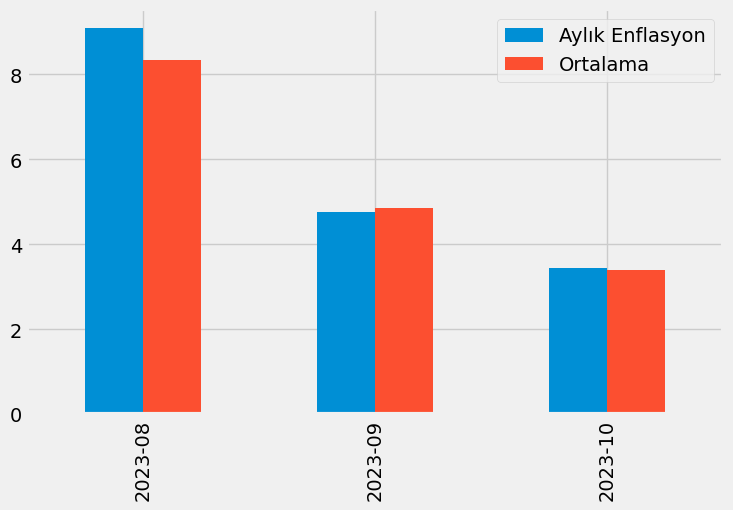

In [55]:
tahminler["Ortalama"]=tahminler.iloc[:,1:].mean(axis=1)
tahminler[["Aylık Enflasyon","Ortalama"]].plot(kind="bar",figsize=(8,5))

In [56]:
model=auto_arima(pfaiz["Politika Faizi"],seasonal=False,information_criterion="bic")
model_fit = model.fit(pfaiz["Politika Faizi"])
faiztahmin = model_fit.predict(25)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2024-01-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin.iloc[4:,0]=[42.5,45,45,45,45,45,45,45,45,45,42.5,40,40,40,40,40,40,40,40,40,40,37.5,35,35,35,35]
faiztahmin

,Politika Faizi
2023-08-31,23.50
2023-09-30,31.00
2023-10-31,33.00
2023-11-30,41.09
2023-12-31,42.50
2024-01-31,45.00
2024-02-29,45.00
2024-03-31,45.00
2024-04-30,45.00
2024-05-31,45.00


In [57]:
model=auto_arima(kfaiz["Kredi Faizi"],seasonal=True,m=9)
model_fit = model.fit(kfaiz["Kredi Faizi"])

forecast = model_fit.predict(26)
kfaiztahmin=pd.DataFrame(forecast)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2024-01-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.290000
2023-09-30,57.560000
2023-10-31,58.430000
2023-11-30,58.610000
2023-12-31,59.690000
2024-01-31,60.067635
2024-02-29,60.199680
2024-03-31,60.245852
2024-04-30,60.261996
2024-05-31,60.267641


In [58]:
trainexog=kfaiz[47:-2]
trainexog

,Kredi Faizi
2010-01-31,13.76
2010-02-28,13.36
2010-03-31,13.10
2010-04-30,13.18
2010-05-31,13.25
...,...
2023-06-30,38.78
2023-07-31,44.58
2023-08-31,45.29
2023-09-30,57.56


In [59]:
testexog=kfaiztahmin[2:]
testexog

,Kredi Faizi
2023-10-31,58.430000
2023-11-30,58.610000
2023-12-31,59.690000
2024-01-31,60.067635
2024-02-29,60.199680
2024-03-31,60.245852
2024-04-30,60.261996
2024-05-31,60.267641
2024-06-30,60.269615
2024-07-31,60.270305


In [60]:
model=auto_arima(mfaiz["Mevduat Faizi"],X=pfaiz,trace=False,seasonal=False,information_criterion="aic")
mfaiztahmin=pd.DataFrame(model.predict(25,X=faiztahmin[5:]))
mfaiztahmin.columns=["Mevduat Faizi"]
row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[-2:,0]},index=pd.date_range(start="2023-11-30",periods=2,freq="1M"))
mfaiztahmin=pd.concat([row,mfaiztahmin],axis=0)
mfaiztahmin


,Mevduat Faizi
2023-11-30,46.070000
2023-12-31,52.600000
2024-01-31,52.810984
2024-02-29,50.932610
2024-03-31,52.414908
2024-04-30,52.411042
2024-05-31,51.781859
2024-06-30,52.124701
2024-07-31,52.206740
2024-08-31,52.016242


In [61]:
trainexog=pd.DataFrame()
trainexog["Dolar"]=usd.iloc[-16:-6,0].rolling(2).mean().dropna()*df14.iloc[:-6,0]
trainexog=trainexog.dropna()
trainexog=np.array(trainexog).reshape(-1,1)
testexog=pd.DataFrame()
testexog["Dolar"]=usd.iloc[-7:,0].rolling(2).mean().dropna()*df14.iloc[-6:,0]
testexog=testexog.dropna()
testexog=np.array(testexog).reshape(-1,1)

In [62]:
exog=pd.DataFrame()
exog["X"]=usd["TP_DK_USD_S_YTL"].rolling(2).mean().dropna()*df14["Brent"]
exog=exog.dropna()
exog
#exog=np.array(exog).reshape(-1,1)


,X
2007-07-31,99.454046
2007-08-31,92.519699
2007-09-30,99.580871
2007-10-31,101.824103
2007-11-30,110.143119
...,...
2023-08-31,2275.241982
2023-09-30,2504.165548
2023-10-31,2432.069312
2023-11-30,2316.594077


In [63]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,49.11,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,35]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-02-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0.00
2023-09-30,0.00
2023-10-31,0.00
2023-11-30,0.00
2023-12-31,0.00
2024-01-31,49.11
2024-02-29,0.00
2024-03-31,0.00
2024-04-30,0.00
2024-05-31,0.00


In [64]:
faiztahmin.columns=["Faiz"]


In [65]:
exogtrain=pd.DataFrame()
exogtrain["Faiz"]=pfaiz["Politika Faizi"].iloc[95:-14]
exogtrain=np.array(exogtrain).reshape(-1,1)

exogtest=pd.DataFrame()
exogtest=pd.concat([pfaiz["Politika Faizi"].iloc[-14:-2],faiztahmin.iloc[2:,0]],axis=0)
exogtest=np.array(exogtest).reshape(-1,1)



In [66]:
exog=pfaiz["Politika Faizi"].iloc[95:-2]
exog=np.array(exog).reshape(-1,1)

In [67]:
exogtest=faiztahmin.iloc[2:]
exogtest=np.array(exogtest).reshape(-1,1)

In [68]:
model=auto_arima(issizlik,seasonal=True,m=3,X=exog)
model_fit = model.fit(issizlik,X=exog)
issizliktahmin = model_fit.predict(28,X=exogtest)
issizliktahmin=pd.DataFrame(issizliktahmin)
issizliktahmin.columns=["İşsizlik"]
issizliktahmin

,İşsizlik
2023-11-30,8.540840
2023-12-31,8.454193
2024-01-31,8.347127
2024-02-29,8.364339
2024-03-31,8.439923
2024-04-30,8.466738
2024-05-31,8.534691
2024-06-30,8.602699
2024-07-31,8.653981
2024-08-31,8.715422


In [69]:
from prophet import Prophet


In [70]:
df6.shape

(215, 1)

In [71]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,500)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df6.index
    sn["y"]=df6.values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=14,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-14])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,500)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df6.index\n    sn["y"]=df6.values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scale=params

In [72]:
'''study.best_params'''

'study.best_params'

In [73]:
sn=pd.DataFrame()
sn["ds"]=df6.index
sn["y"]=df6.values
sn["cap"]=285.7233032513667
prophet=Prophet(growth="linear",changepoint_prior_scale=4.913477926048151,changepoint_range=0.8995647346860385,seasonality_prior_scale=5.929453787047488,n_changepoints=24,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=285.7233032513667
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:22 - cmdstanpy - INFO - Chain [1] start processing
22:25:22 - cmdstanpy - INFO - Chain [1] done processing


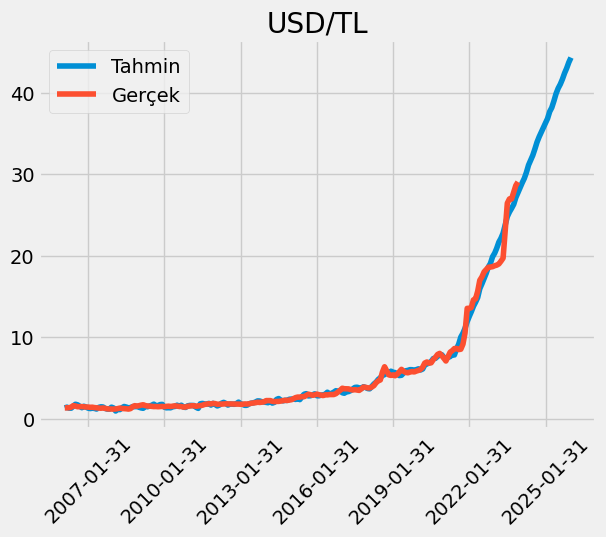

In [74]:
plt.title("USD/TL")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(df6["USD/TL"],label="Gerçek")
plt.xticks(predictions.index[11::36],rotation=45)
plt.legend()
plt.show()

In [75]:
usdtahmin=(predictions["yhat"][-26:].pct_change(periods=1)*100).dropna()
usdtahmin

ds
2024-01-31    2.191414
2024-02-29    2.024928
2024-03-31    1.931592
2024-04-30    2.449031
2024-05-31    3.009359
2024-06-30    1.919629
2024-07-31    1.894936
2024-08-31    2.455042
2024-09-30    2.494550
2024-10-31    1.948040
2024-11-30    1.636628
2024-12-31    1.652485
2025-01-31    1.579220
2025-02-28    1.409821
2025-03-31    2.331061
2025-04-30    1.298345
2025-05-31    2.144080
2025-06-30    2.261357
2025-07-31    1.689020
2025-08-31    1.243289
2025-09-30    1.488795
2025-10-31    1.787301
2025-11-30    1.409990
2025-12-31    1.692063
2026-01-31    1.334649
Name: yhat, dtype: float64

In [76]:
usdtahmin1 = []
result = df6.iloc[-1,0]
for i in range(len(usdtahmin)):
    result *= (1 + usdtahmin[i] / 100)
    usdtahmin1.append(result)

usdtahmin1 = np.array(usdtahmin1).reshape(-1, 1)
usdtahmin1 = pd.DataFrame(usdtahmin1)
usdtahmin1.columns = ["USD/TL"]
usdtahmin1=pd.concat([df6.iloc[-5:],usdtahmin1],axis=0)
usdtahmin1 = usdtahmin1.set_index(pd.date_range(start="2023-08-30", periods=len(usdtahmin1), freq="1M"))
usdtahmin1

,USD/TL
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.637082
2023-12-31,29.076114
2024-01-31,29.713292
2024-02-29,30.314965
2024-03-31,30.900527
2024-04-30,31.657290
2024-05-31,32.609972


In [77]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.01,0.99),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'm':trial.suggest_int('m',0,180),
                'cap':trial.suggest_int('cap',1,1000)
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df14[params["m"]:-12].index
    sn["y"]=df14[params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"])
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df14["Brent"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.01,0.99),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'m\':trial.suggest_int(\'m\',0,180),\n                \'cap\':trial.suggest_int(\'cap\',1,1000)\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df14[params["m"]:-12].index\n    sn["y"]=df14[params["m"]:-12].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"])\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=12,freq="M")\n    future_dates["cap"]=params["cap"]\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(

In [78]:
#study.best_params

In [79]:
sn=pd.DataFrame()
sn["ds"]=df14[51:].index
sn["y"]=df14[51:].values
sn["cap"]=741
prophet=Prophet(growth="logistic",changepoint_prior_scale=9.40940230511886,changepoint_range=0.26678385022653445)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=13,freq="M")
future_dates["cap"]=741
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:25:23 - cmdstanpy - INFO - Chain [1] start processing


22:25:23 - cmdstanpy - INFO - Chain [1] done processing


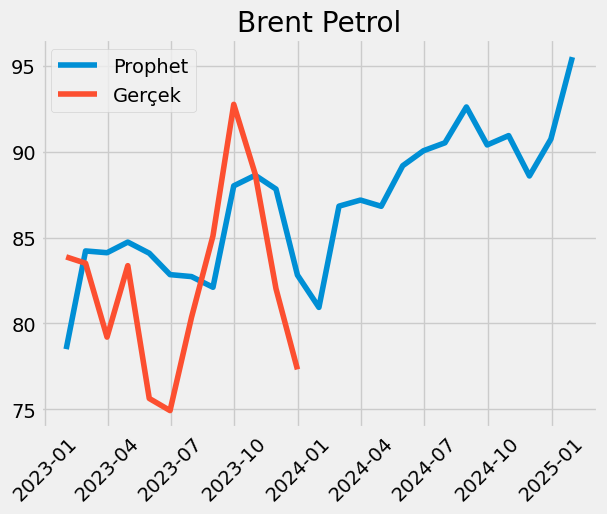

In [80]:
plt.title("Brent Petrol")
plt.plot(predictions["yhat"][-25:],label="Prophet")
plt.plot(df14["Brent"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [81]:
'''from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping

train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Modeli optimize etmek için kullanılabilecek farklı parametre kombinasyonlarını deneme
layer_units = [64, 128]  # LSTM katmanındaki nöron sayısı
dense_units = [16,32,64,128]  # Yoğun katmandaki nöron sayısı
activations = ['relu', 'tanh','sigmoid','elu','selu']  # Aktivasyon fonksiyonları
learning_rates = [0.001, 0.01]  # Öğrenme hızı
optimizers = ['adam', 'sgd']  # Optimizer'lar

best_mse = float('inf')
best_model = None

for lstm_units in layer_units:
    for dense_unit in dense_units:
        for activation in activations:
            for learning_rate in learning_rates:
                for optimizer_name in optimizers:
                    try:
                        # Modeli oluşturma
                        model = Sequential()
                        model.add(LSTM(units=lstm_units, activation=activation, input_shape=(X_train.shape[1], X_train.shape[2])))
                        model.add(Dense(units=dense_unit, activation=activation))
                        model.add(Dense(units=1))
                        
                        # Optimizer'ı ve learning rate'i ayarlama
                        if optimizer_name == 'adam':
                            optimizer = Adam(learning_rate=learning_rate)
                        elif optimizer_name == 'sgd':
                            optimizer = SGD(learning_rate=learning_rate)  # SGD için gerekirse import etmeyi unutmayın
                        
                        model.compile(optimizer=optimizer, loss='mean_squared_error')
                        
                        # Modeli eğitme ve early stopping uygulama
                        model.fit(X_train, y_train, epochs=250, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)
                        
                        # Modeli değerlendirme
                        y_pred = model.predict(X_test)
                        mse = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_pred))
                        
                        # En iyi modeli güncelleme
                        if mse < best_mse:
                            best_mse = mse
                            best_model = model
                    except Exception as e:
                        print(f'Hata oluştu: {e}')

# En iyi modelin MSE değerini ve kullanılan optimizer'ı yazdırma
print(f'En İyi Modelin Ortalama Kare Hatası (MSE): {best_mse}')
if best_model is not None:
    print(f'En İyi Modelde Kullanılan Optimizer: {best_model.optimizer.get_config()["name"]}')
'''

'from sklearn.model_selection import train_test_split\nfrom tensorflow.keras.optimizers import Adam,SGD\nfrom tensorflow.keras.callbacks import EarlyStopping\n\ntrain_size=-12\n# Veriyi eğitim ve test setlerine bölme\n\nX_train, X_test = X[:train_size], X[train_size:]\ny_train, y_test = y[:train_size], y[train_size:]\n\n# Early stopping\nearly_stopping = EarlyStopping(monitor=\'val_loss\', patience=10, restore_best_weights=True)\n\n# Modeli optimize etmek için kullanılabilecek farklı parametre kombinasyonlarını deneme\nlayer_units = [64, 128]  # LSTM katmanındaki nöron sayısı\ndense_units = [16,32,64,128]  # Yoğun katmandaki nöron sayısı\nactivations = [\'relu\', \'tanh\',\'sigmoid\',\'elu\',\'selu\']  # Aktivasyon fonksiyonları\nlearning_rates = [0.001, 0.01]  # Öğrenme hızı\noptimizers = [\'adam\', \'sgd\']  # Optimizer\'lar\n\nbest_mse = float(\'inf\')\nbest_model = None\n\nfor lstm_units in layer_units:\n    for dense_unit in dense_units:\n        for activation in activations:\n  

In [82]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df14)

# LSTM için veriyi hazırlama
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # Örnek olarak 12 aylık bir dönemi kullanıyoruz
X, y = prepare_data(df_scaled, time_steps)
train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
keras.utils.set_random_seed(7)
model = Sequential()
model.add(LSTM(units=128, activation='sigmoid', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=16, activation='sigmoid'))
model.add(Dense(units=1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/100
10/10 [==============================] - 3s 55ms/step - loss: 0.1923 - val_loss: 0.1956
Epoch 2/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0810 - val_loss: 0.0168
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0699 - val_loss: 0.0626
Epoch 4/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0614 - val_loss: 0.0281
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0566 - val_loss: 0.0394
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0539 - val_loss: 0.0309
Epoch 7/100
10/10 [==============================] - 0s 12ms/step - loss: 0.0538 - val_loss: 0.0345
Epoch 8/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0542 - val_loss: 0.0533
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0490 - val_loss: 0.0171
Epoch 10/100
10/10 [==============================] - 0s 13ms/step - loss: 0.0466 - val_loss: 0.0493

1/1 [==============================] - 0s 240ms/step


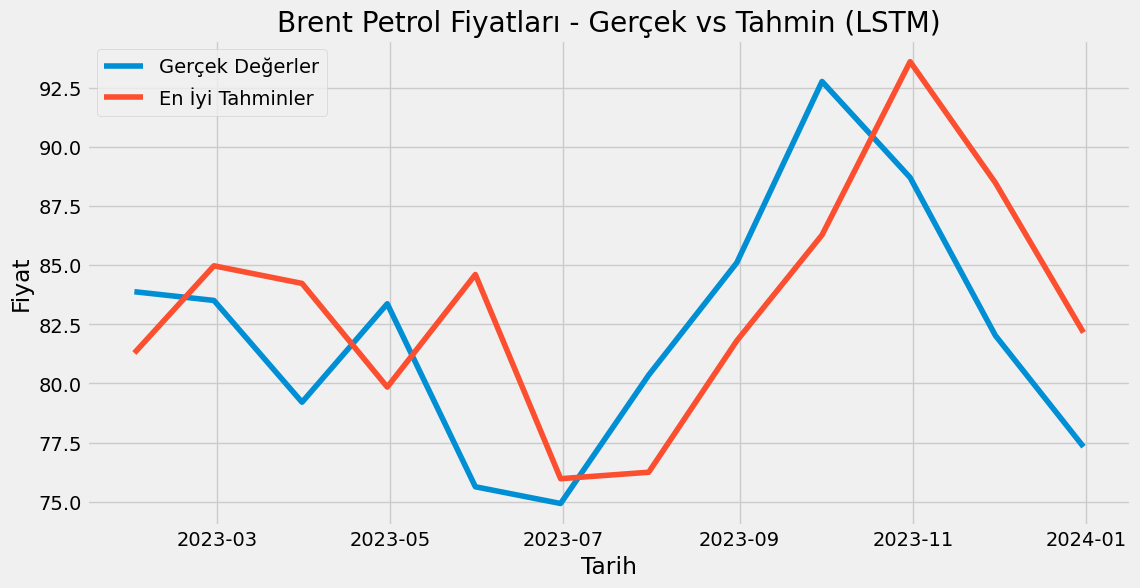

In [83]:
pred=scaler.inverse_transform(model.predict(X_test))
plt.figure(figsize=(12, 6))
plt.plot(df14.index[-len(y_test):], scaler.inverse_transform(y_test), label='Gerçek Değerler')
plt.plot(df14.index[-len(y_test):], pred, label='En İyi Tahminler')
plt.title('Brent Petrol Fiyatları - Gerçek vs Tahmin (LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()

In [84]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df14)

# LSTM için veriyi hazırlama
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12  # Örnek olarak 12 aylık bir dönemi kullanıyoruz
X, y = prepare_data(df_scaled, time_steps)
train_size=-12
# Veriyi eğitim ve test setlerine bölme

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [85]:
# generate the input and output sequences
n_lookback = 25  # length of input sequences (lookback period)
n_forecast = 25  # length of output sequences (forecast period)
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)
keras.utils.set_random_seed(0)
# fit the model
model = Sequential()
model.add(LSTM(units=128, activation='sigmoid', return_sequences=True, input_shape=(n_lookback, 1)))
model.add(Dense(units=16, activation='sigmoid'))  # Dense katmanı eklendi
model.add(Dense(units=1))  # Çıkış birimi sayısını 1 olarak değiştirildi

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=16, verbose=1)

# generate the forecasts
X_ = y[-n_lookback:]  # last available input sequence
#X_ = X_.reshape(1, n_lookback, 1)

# Tahmin yaparken çıkış şeklini düzenle
Y_ = model.predict(X_).reshape(1, n_forecast)

# Orijinal ölçekleme işlemi
Y_ = scaler.inverse_transform(Y_)

print(Y_)



Epoch 1/100
9/9 [==============================] - 2s 18ms/step - loss: 0.4443
Epoch 2/100
9/9 [==============================] - 0s 17ms/step - loss: 0.1067
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0949
Epoch 4/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0753
Epoch 5/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0720
Epoch 6/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0670
Epoch 7/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0665
Epoch 8/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0651
Epoch 9/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0643
Epoch 10/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0638
Epoch 11/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0628
Epoch 12/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0622
Epoch 13/100
9/9 [==============================]

In [86]:
Y_=np.array(Y_).reshape(-1,1)

In [87]:
future=pd.DataFrame()
future["Brent"]=df14["Brent"]
Y_=pd.DataFrame(Y_)
Y_.columns=["Brent"]
Y_=Y_.set_index(pd.date_range(start="2024-01-31",periods=25,freq="M"))
future=pd.concat([future,Y_],axis=0)
future

,Brent
2007-07-31,76.395000
2007-08-31,71.258696
2007-09-30,77.135263
2007-10-31,82.456957
2007-11-30,92.060953
...,...
2025-09-30,76.645027
2025-10-31,76.906212
2025-11-30,76.767776
2025-12-31,76.540070


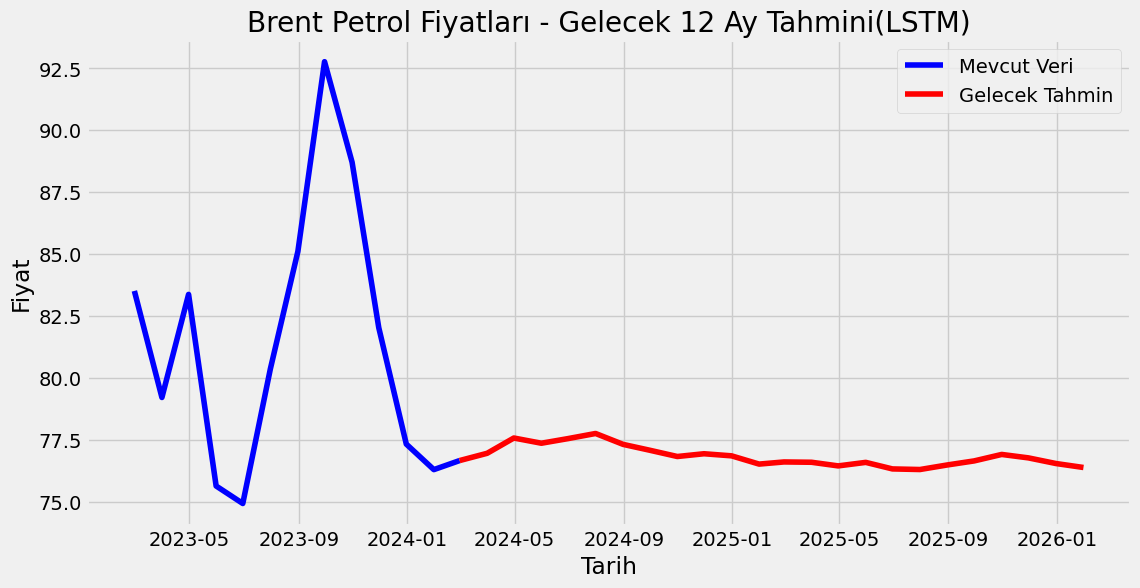

In [88]:
plt.figure(figsize=(12, 6))
#plt.plot(pred,label='Test Tahmini',color='green')
plt.plot(future["Brent"][-36:-23], label='Mevcut Veri',color='blue')
plt.plot(future["Brent"][-24:] ,label='Gelecek Tahmin',color='red')
plt.title('Brent Petrol Fiyatları - Gelecek 12 Ay Tahmini(LSTM)')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.show()


In [89]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.0001,0.9999),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.001,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,50),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400),
                'm':trial.suggest_int('m',0,105)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=enf_belirsizlik[params["m"]:].index
    sn["y"]=enf_belirsizlik[params["m"]:].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=13,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"][:-13])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.0001,0.9999),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.001,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,50),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400),\n                \'m\':trial.suggest_int(\'m\',0,105)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=enf_belirsizlik[params["m"]:].index\n    sn["y"]=en

In [90]:
model=auto_arima(enf_belirsizlik,trace=False,information_criterion='aic',seasonal=True,m=5)
enfbelirsizliktahmin1=model.predict(25)
enfbelirsizliktahmin1=pd.DataFrame(enfbelirsizliktahmin1)
enfbelirsizliktahmin1.columns=["Enflasyon Belirsizliği"]
row=pd.DataFrame({"Enflasyon Belirsizliği":enf_belirsizlik.iloc[-1:,0]},index=pd.date_range(start="2023-12-30",periods=1,freq="1M"))
enfbelirsizliktahmin1=pd.concat([row,enfbelirsizliktahmin1],axis=0)
enfbelirsizliktahmin1


,Enflasyon Belirsizliği
2023-12-31,3.360000
2024-01-31,2.395268
2024-02-29,2.705154
2024-03-31,2.729013
2024-04-30,2.666159
2024-05-31,1.887541
2024-06-30,1.270527
2024-07-31,1.320320
2024-08-31,1.879789
2024-09-30,2.188238


In [91]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',[0.01,10]),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].index
    sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],predictions["yhat"].tail(12))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',[0.01,10]),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][p

In [92]:
#study.best_params

In [93]:
sn=pd.DataFrame()
sn["ds"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].index
sn["y"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][80:].values
sn["cap"]=190
prophet=Prophet(changepoint_prior_scale=3.481321992729419,changepoint_range=0.8995930316928846,growth='linear',seasonality_prior_scale=8.977376335194005,yearly_seasonality=True,weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=190
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:26:14 - cmdstanpy - INFO - Chain [1] start processing
22:26:14 - cmdstanpy - INFO - Chain [1] done processing


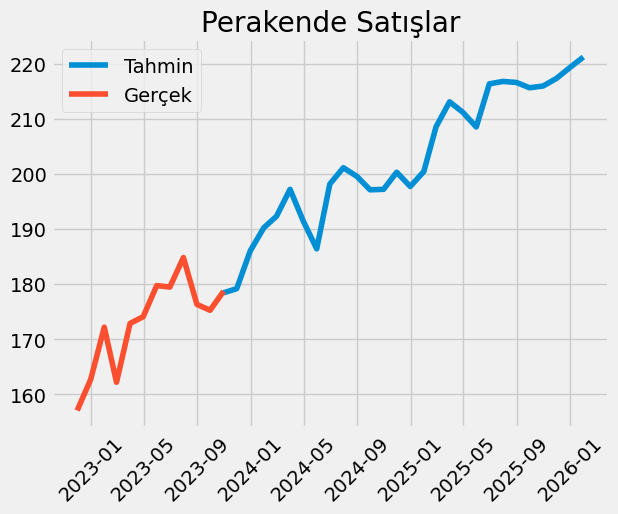

In [94]:
plt.title("Perakende Satışlar")
plt.plot(predictions["yhat"][-28:],label="Tahmin")
plt.plot(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [95]:
perakendetahmin=(predictions["yhat"][-28:].pct_change(periods=1)*100).dropna()
perakendetahmin

ds
2023-11-30    0.417766
2023-12-31    3.837414
2024-01-31    2.255112
2024-02-29    1.093496
2024-03-31    2.545369
2024-04-30   -2.901185
2024-05-31   -2.657283
2024-06-30    6.315988
2024-07-31    1.493700
2024-08-31   -0.782232
2024-09-30   -1.221874
2024-10-31    0.044657
2024-11-30    1.575699
2024-12-31   -1.293369
2025-01-31    1.373530
2025-02-28    4.050079
2025-03-31    2.179169
2025-04-30   -0.886073
2025-05-31   -1.268685
2025-06-30    3.756526
2025-07-31    0.201727
2025-08-31   -0.087168
2025-09-30   -0.445215
2025-10-31    0.148098
2025-11-30    0.628616
2025-12-31    0.911598
2026-01-31    0.878391
Name: yhat, dtype: float64

In [96]:
motorintahmin=pd.DataFrame((1+(((usdtahmin1[2:].pct_change(periods=1)*100).dropna())/100)).values*(1+(((future[-28:].pct_change(periods=1)*100).dropna())/100)).values)
motorintahmin.columns=["Motorin"]
motorintahmin=motorintahmin.set_index(pd.date_range(start="2023-11-30",periods=len(motorintahmin),freq="1M"))
motorintahmin.iloc[0,0]=(motorin.pct_change(periods=1)*100).iloc[-1,0]
motorintahmin[1:]=((motorintahmin[1:])-1)*100
motorintahmin

,Motorin
2023-11-30,-3.136247
2023-12-31,-4.289135
2024-01-31,0.829570
2024-02-29,2.514232
2024-03-31,2.322167
2024-04-30,3.270154
2024-05-31,2.729537
2024-06-30,2.165853
2024-07-31,2.166142
2024-08-31,1.875197


In [97]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=money["Para Arzi"][params["m"]:-12].index
    sn["y"]=money["Para Arzi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(money["Para Arzi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=money["Para Arzi"][params["m"]:-12].index\n    sn["y"]=money["Para Arzi"][

In [98]:
#study.best_params

In [99]:
sn=pd.DataFrame()
sn["ds"]=money["Para Arzi"][110:].index
sn["y"]=money["Para Arzi"][110:].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=0.17670782903839727,changepoint_range=0.8995442051379563,growth='linear',seasonality_prior_scale=9.026889153868014)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:26:15 - cmdstanpy - INFO - Chain [1] start processing
22:26:15 - cmdstanpy - INFO - Chain [1] done processing


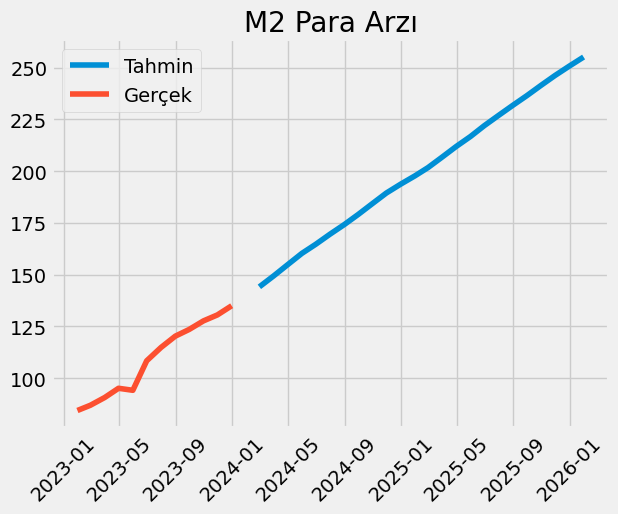

In [100]:
plt.title("M2 Para Arzı")
plt.plot(predictions["yhat"][-24:],label="Tahmin")
plt.plot(money["Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [101]:
paraarzitahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(25)
paraarzitahmin

ds
2024-01-31    3.774062
2024-02-29    2.290557
2024-03-31    3.675009
2024-04-30    3.591406
2024-05-31    3.553608
2024-06-30    2.745467
2024-07-31    2.972767
2024-08-31    2.746631
2024-09-30    2.791120
2024-10-31    2.954662
2024-11-30    2.752969
2024-12-31    2.261140
2025-01-31    2.079514
2025-02-28    1.996440
2025-03-31    2.546505
2025-04-30    2.446989
2025-05-31    2.281334
2025-06-30    2.423039
2025-07-31    2.239984
2025-08-31    2.157609
2025-09-30    1.988595
2025-10-31    2.125912
2025-11-30    1.953802
2025-12-31    1.844624
2026-01-31    1.752261
Name: yhat, dtype: float64

In [102]:
paraarzitahmin1 = []
result = money.iloc[-1,0]
for i in range(len(paraarzitahmin)):
    result *= (1 + paraarzitahmin[i] / 100)
    paraarzitahmin1.append(result)

paraarzitahmin1 = np.array(paraarzitahmin1).reshape(-1, 1)
paraarzitahmin1 = pd.DataFrame(paraarzitahmin1)
paraarzitahmin1.columns = ["Para Arzi"]
paraarzitahmin1 = paraarzitahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(paraarzitahmin1), freq="1M"))
row=pd.DataFrame({"Para Arzi":money.iloc[-4:,0]},index=pd.date_range(start="2023-09-30",periods=4,freq="M"))
paraarzitahmin1=pd.concat([row,paraarzitahmin1])
paraarzitahmin1

,Para Arzi
2023-09-30,123.493100
2023-10-31,127.637895
2023-11-30,130.504631
2023-12-31,134.940475
2024-01-31,140.033211
2024-02-29,143.240751
2024-03-31,148.504862
2024-04-30,153.838275
2024-05-31,159.305084
2024-06-30,163.678753


In [103]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,200)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=borc["Borç"][params["m"]:-12].index
    sn["y"]=borc["Borç"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(borc["Borç"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,200)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=borc["Borç"][params["m"]:-12].index\n    sn["y"]=borc["Borç

In [104]:
#study.best_params

In [105]:
sn=pd.DataFrame()
sn["ds"]=borc["Borç"][103:].index
sn["y"]=borc["Borç"][103:].values
sn["cap"]=100
prophet=Prophet(changepoint_prior_scale=3.671534257218686,changepoint_range=0.8995013103592469,growth='linear',seasonality_prior_scale=4.464356522636207,n_changepoints=2)

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=26,freq="M")
future_dates["cap"]=100
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:26:15 - cmdstanpy - INFO - Chain [1] start processing
22:26:15 - cmdstanpy - INFO - Chain [1] done processing


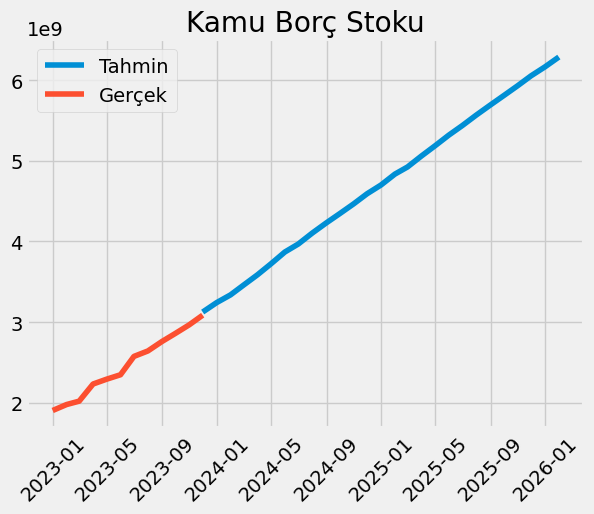

In [106]:
plt.title("Kamu Borç Stoku")
plt.plot(predictions["yhat"][-27:],label="Tahmin")
plt.plot(borc["Borç"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [107]:
borctahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(26)
borctahmin

ds
2023-12-31    3.723207
2024-01-31    2.973918
2024-02-29    3.622697
2024-03-31    3.698124
2024-04-30    3.781603
2024-05-31    3.941290
2024-06-30    2.569477
2024-07-31    3.410054
2024-08-31    3.046820
2024-09-30    2.720313
2024-10-31    2.789277
2024-11-30    2.814606
2024-12-31    2.363137
2025-01-31    2.875181
2025-02-28    1.826525
2025-03-31    2.758137
2025-04-30    2.475739
2025-05-31    2.578391
2025-06-30    2.222283
2025-07-31    2.388002
2025-08-31    2.217814
2025-09-30    2.062221
2025-10-31    2.105032
2025-11-30    2.082993
2025-12-31    1.837468
2026-01-31    1.980440
Name: yhat, dtype: float64

In [108]:
borctahmin1 = []
result = borc.iloc[-1,0]
for i in range(len(borctahmin)):
    result *= (1 + borctahmin[i] / 100)
    borctahmin1.append(result)

borctahmin1 = np.array(borctahmin1).reshape(-1, 1)
borctahmin1 = pd.DataFrame(borctahmin1)
borctahmin1.columns = ["Borç"]
borctahmin1 = borctahmin1.set_index(pd.date_range(start="2023-12-30", periods=len(borctahmin1), freq="1M"))
row=pd.DataFrame({"Borç":borc.iloc[-4:,0]},index=pd.date_range(start="2023-08-30",periods=4,freq="1M"))
borctahmin1=pd.concat([row,borctahmin1],axis=0)
borctahmin1

,Borç
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.966763e+09
2023-11-30,3.086466e+09
2023-12-31,3.201382e+09
2024-01-31,3.296589e+09
2024-02-29,3.416014e+09
2024-03-31,3.542342e+09
2024-04-30,3.676300e+09
2024-05-31,3.821193e+09


In [109]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=df3["Kredi"][params["m"]:-12].index
    sn["y"]=df3["Kredi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(df3["Kredi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,200),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=df3["Kredi"][params["m"]:-12].index\n    sn["y"]=df3["Kredi"][params["m"]:

In [110]:
#study.best_params

In [111]:
sn=pd.DataFrame()
sn["ds"]=df3["Kredi"][150:].index
sn["y"]=df3["Kredi"][150:].values
sn["cap"]=381.79609705677035
prophet=Prophet(changepoint_prior_scale=2.10520609698171,changepoint_range=0.6734967268169046,growth='logistic',seasonality_prior_scale=4.921223978299016,n_changepoints=6,yearly_seasonality=True,weekly_seasonality='auto')

prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=381.79609705677035
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:26:16 - cmdstanpy - INFO - Chain [1] start processing


22:26:17 - cmdstanpy - INFO - Chain [1] done processing


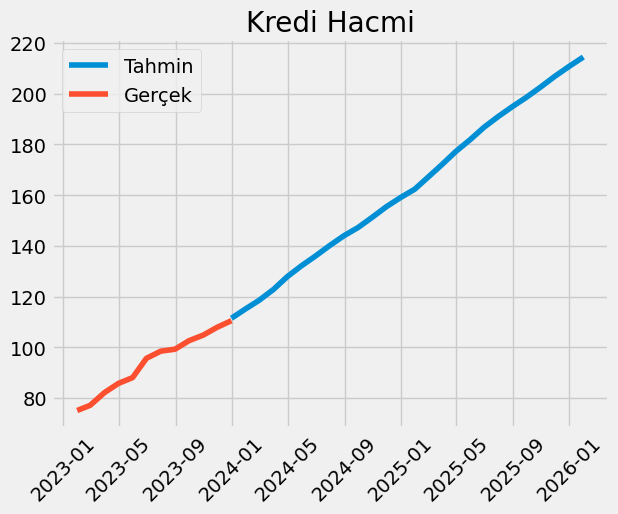

In [112]:
plt.title("Kredi Hacmi")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(df3["Kredi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [113]:
kreditahmin=(predictions["yhat"].pct_change(periods=1)*100).tail(25)
kreditahmin

ds
2024-01-31    3.355520
2024-02-29    2.904780
2024-03-31    3.607285
2024-04-30    4.112492
2024-05-31    3.377116
2024-06-30    2.880308
2024-07-31    3.062780
2024-08-31    2.768246
2024-09-30    2.201628
2024-10-31    2.764216
2024-11-30    2.710353
2024-12-31    2.344730
2025-01-31    2.094785
2025-02-28    2.831613
2025-03-31    3.063891
2025-04-30    3.001599
2025-05-31    2.628451
2025-06-30    2.678787
2025-07-31    2.286780
2025-08-31    2.066388
2025-09-30    1.861054
2025-10-31    2.048588
2025-11-30    2.041393
2025-12-31    1.894348
2026-01-31    1.763262
Name: yhat, dtype: float64

In [114]:
kreditahmin1 = []
result = df3.iloc[-1,0]
for i in range(len(kreditahmin)):
    result *= (1 + kreditahmin[i] / 100)
    kreditahmin1.append(result)

kreditahmin1 = np.array(kreditahmin1).reshape(-1, 1)
kreditahmin1 = pd.DataFrame(kreditahmin1)
kreditahmin1.columns = ["Kredi"]
kreditahmin1 = kreditahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(kreditahmin1), freq="1M"))
row=pd.DataFrame({"Kredi":df3.iloc[-3:,0]},index=pd.date_range(start="2023-10-30",periods=3,freq="1M"))
kreditahmin1=pd.concat([row,kreditahmin1],axis=0)
kreditahmin1

,Kredi
2023-10-31,104.793503
2023-11-30,107.866144
2023-12-31,110.480700
2024-01-31,114.187902
2024-02-29,117.504810
2024-03-31,121.743543
2024-04-30,126.750237
2024-05-31,131.030739
2024-06-30,134.804828
2024-07-31,138.933603


In [115]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,200),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index
    sn["y"]=m3["M3 Para Arzi"][params["m"]:-12].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=12,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(m3["M3 Para Arzi"][-12:],predictions["yhat"][-12:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,200),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=m3["M3 Para Arzi"][params["m"]:-12].index\n    sn["y"]=m3["M3 Para Arzi"][

In [116]:
#study.best_params

In [117]:
sn=pd.DataFrame()
sn["ds"]=m3["M3 Para Arzi"][151:].index
sn["y"]=m3["M3 Para Arzi"][151:].values
sn["cap"]=386.728728252815
prophet=Prophet(changepoint_prior_scale=1.0239522189165728,changepoint_range=0.8631788185438879,growth='logistic',seasonality_prior_scale=8.271825948806738,n_changepoints=14,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=25,freq="M")
future_dates["cap"]=386.728728252815
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:26:17 - cmdstanpy - INFO - Chain [1] start processing


22:26:20 - cmdstanpy - INFO - Chain [1] done processing


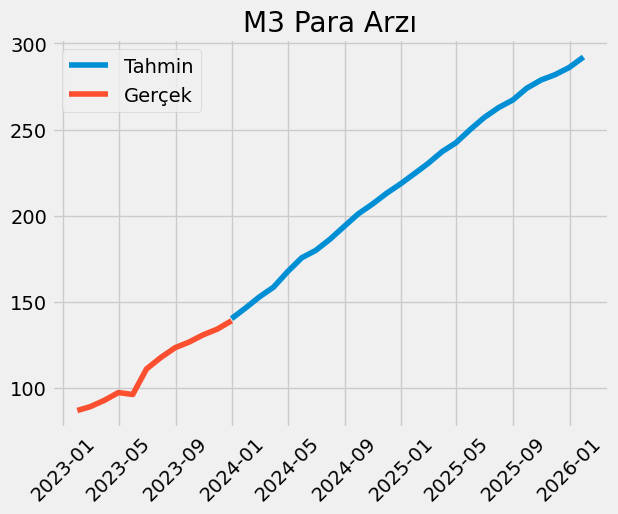

In [118]:
plt.title("M3 Para Arzı")
plt.plot(predictions["yhat"][-26:],label="Tahmin")
plt.plot(m3["M3 Para Arzi"][-12:],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [119]:
m3tahmin=(predictions["yhat"].tail(26).pct_change(periods=1)*100).dropna()
m3tahmin1 = []
result = m3.iloc[-1,0]
for i in range(len(m3tahmin)):
    result *= (1 + m3tahmin[i] / 100)
    m3tahmin1.append(result)

m3tahmin1 = np.array(m3tahmin1).reshape(-1, 1)
m3tahmin1 = pd.DataFrame(m3tahmin1)
m3tahmin1.columns = ["M3"]
m3tahmin1 = m3tahmin1.set_index(pd.date_range(start="2024-01-30", periods=len(m3tahmin1), freq="1M"))
row=pd.DataFrame({"M3":m3.iloc[-3:,0]},index=pd.date_range(start="2023-10-30",periods=3,freq="1M"))
m3tahmin1=pd.concat([row,m3tahmin1],axis=0)
m3tahmin1

,M3
2023-10-31,130.934676
2023-11-30,134.161244
2023-12-31,139.043908
2024-01-31,145.319213
2024-02-29,151.500324
2024-03-31,157.202595
2024-04-30,165.986515
2024-05-31,174.090976
2024-06-30,178.269843
2024-07-31,184.734173


In [120]:
'''import optuna
def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=sanayi["Sanayi"].index
    sn["y"]=sanayi["Sanayi"].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=15,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sanayi["Sanayi"],predictions["yhat"][:-15])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'import optuna\ndef objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=sanayi["Sanayi"].index\n    sn["y"]=sanayi["Sanayi"].values\n    sn["cap"]=params["cap"]\n    prophet=Prophet(cha

In [121]:
#study.best_params

In [122]:
sn=pd.DataFrame()
sn["ds"]=sanayi["Sanayi"].index
sn["y"]=sanayi["Sanayi"].values
prophet=Prophet(changepoint_prior_scale=9.619978429571834,changepoint_range=0.8872026398316396,growth='linear',seasonality_prior_scale=4.66384076344283,n_changepoints=25,yearly_seasonality="auto",weekly_seasonality=True)
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:26:21 - cmdstanpy - INFO - Chain [1] start processing
22:26:21 - cmdstanpy - INFO - Chain [1] done processing


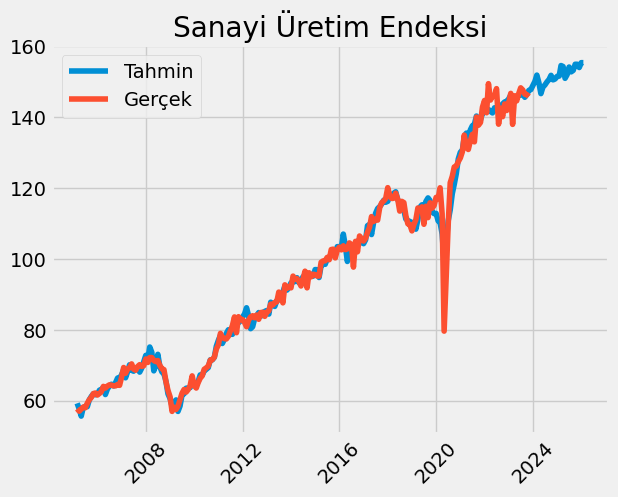

In [123]:
plt.title("Sanayi Üretim Endeksi")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(sanayi["Sanayi"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [124]:
sanayitahmin=(predictions["yhat"].tail(28).pct_change(periods=1)*100).dropna()
sanayitahmin1 = []
result = df3.iloc[-1,0]
for i in range(len(sanayitahmin)):
    result *= (1 + sanayitahmin[i] / 100)
    sanayitahmin1.append(result)

sanayitahmin1 = np.array(sanayitahmin1).reshape(-1, 1)
sanayitahmin1 = pd.DataFrame(sanayitahmin1)
sanayitahmin1.columns = ["Sanayi"]
sanayitahmin1 = sanayitahmin1.set_index(pd.date_range(start="2023-11-30", periods=len(sanayitahmin1), freq="1M"))
#row=pd.DataFrame({"Sanayi":df3.iloc[-2:,0]},index=pd.date_range(start="2023-10-30",periods=2,freq="1M"))
#sanayitahmin1=pd.concat([row,sanayitahmin1],axis=0)
sanayitahmin1

,Sanayi
2023-11-30,110.647583
2023-12-31,111.515220
2024-01-31,112.397145
2024-02-29,113.715548
2024-03-31,112.084066
2024-04-30,109.804564
2024-05-31,111.187600
2024-06-30,111.634822
2024-07-31,112.277843
2024-08-31,112.790219


In [125]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 10),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,0.9),
                'growth': trial.suggest_categorical('growth', ['linear', 'logistic']),
                'seasonality_prior_scale':trial.suggest_float('seasonality_prior_scale',0.01,10),
                'n_changepoints':trial.suggest_int('n_changepoints',1,25),
                'yearly_seasonality':trial.suggest_categorical('yearly_seasonality',[True,False,"auto"]),
                'weekly_seasonality':trial.suggest_categorical('weekly_seasonality',[True,False,"auto"]),
                'm':trial.suggest_int('m',0,110),
                'cap':trial.suggest_float('cap',0,400)

                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redkt["REDKT"][params["m"]:-36].index
    sn["y"]=redkt["REDKT"][params["m"]:-36].values
    sn["cap"]=params["cap"]
    prophet=Prophet(changepoint_prior_scale=params["changepoint_prior_scale"],changepoint_range=params["changepoint_range"],growth=params["growth"],seasonality_prior_scale=params["seasonality_prior_scale"],n_changepoints=params["n_changepoints"],yearly_seasonality=params["yearly_seasonality"],weekly_seasonality=params["weekly_seasonality"],)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=36,freq="M")
    future_dates["cap"]=params["cap"]
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(redkt["REDKT"][-36:],predictions["yhat"][-36:])
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.001, 10),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,0.9),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'linear\', \'logistic\']),\n                \'seasonality_prior_scale\':trial.suggest_float(\'seasonality_prior_scale\',0.01,10),\n                \'n_changepoints\':trial.suggest_int(\'n_changepoints\',1,25),\n                \'yearly_seasonality\':trial.suggest_categorical(\'yearly_seasonality\',[True,False,"auto"]),\n                \'weekly_seasonality\':trial.suggest_categorical(\'weekly_seasonality\',[True,False,"auto"]),\n                \'m\':trial.suggest_int(\'m\',0,110),\n                \'cap\':trial.suggest_float(\'cap\',0,400)\n\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redkt["REDKT"][params["m"]:-36].index\n    sn["y"]=redkt["REDKT"][params[

In [126]:
#study.best_params

In [127]:
sn=pd.DataFrame()
sn["ds"]=redkt["REDKT"].index
sn["y"]=redkt["REDKT"].values
sn["cap"]=300
prophet=Prophet(changepoint_prior_scale=4.998474885835357,
 changepoint_range=0.8719913329652468,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=14,freq="M")
future_dates["cap"]=300
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:26:21 - cmdstanpy - INFO - Chain [1] start processing
22:26:22 - cmdstanpy - INFO - Chain [1] done processing


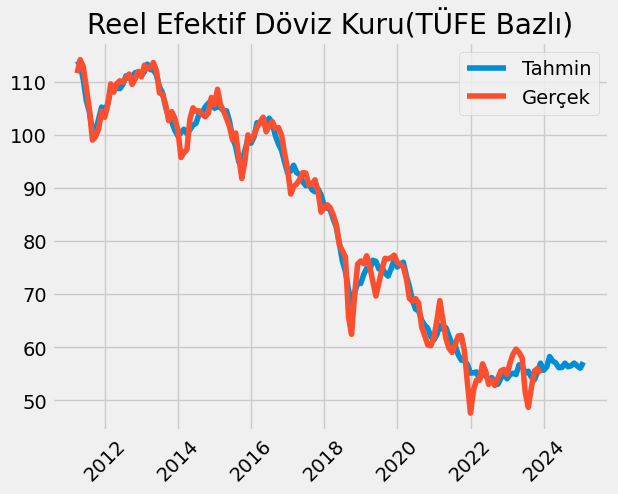

In [128]:
plt.title("Reel Efektif Döviz Kuru(TÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redkt["REDKT"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [129]:
predictions["yhat"].tail(15)

ds
2023-11-30    57.016442
2023-12-31    55.680358
2024-01-31    56.309661
2024-02-29    58.274112
2024-03-31    57.428478
2024-04-30    57.089969
2024-05-31    56.172834
2024-06-30    56.211509
2024-07-31    57.022767
2024-08-31    56.360198
2024-09-30    56.528234
2024-10-31    57.037651
2024-11-30    56.514103
2024-12-31    56.071645
2025-01-31    57.206708
Name: yhat, dtype: float64

In [130]:
redkttahmin=predictions["yhat"].tail(27)
redkttahmin=pd.DataFrame(redkttahmin)
redkttahmin.columns=["REDKT"]
redkttahmin=redkttahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redkttahmin

,REDKT
2023-12-31,55.124752
2024-01-31,54.100201
2024-02-29,54.903269
2024-03-31,55.120650
2024-04-30,54.896201
2024-05-31,56.713874
2024-06-30,56.546257
2024-07-31,55.152070
2024-08-31,55.504813
2024-09-30,54.386131


In [131]:
'''def objective(trial):
    params = {
        
        'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.005, 5),
                'changepoint_range': trial.suggest_float('changepoint_range', 0.1,1.0),
                'growth': trial.suggest_categorical('growth', ['logistic','linear'])
                
    }
    
    sn=pd.DataFrame()
    sn["ds"]=redk["REDK"].index
    sn["y"]=redk["REDK"].values
    sn["cap"]=100
    prophet=Prophet(**params)
    prophet.fit(sn)
    future_dates=prophet.make_future_dataframe(periods=27,freq="M")
    future_dates["cap"]=100
    predictions=prophet.predict(future_dates)
    predictions=predictions.set_index(predictions["ds"])
    
    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))
    return mae_score
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=2000)'''

'def objective(trial):\n    params = {\n        \n        \'changepoint_prior_scale\': trial.suggest_float(\'changepoint_prior_scale\', 0.005, 5),\n                \'changepoint_range\': trial.suggest_float(\'changepoint_range\', 0.1,1.0),\n                \'growth\': trial.suggest_categorical(\'growth\', [\'logistic\',\'linear\'])\n                \n    }\n    \n    sn=pd.DataFrame()\n    sn["ds"]=redk["REDK"].index\n    sn["y"]=redk["REDK"].values\n    sn["cap"]=100\n    prophet=Prophet(**params)\n    prophet.fit(sn)\n    future_dates=prophet.make_future_dataframe(periods=27,freq="M")\n    future_dates["cap"]=100\n    predictions=prophet.predict(future_dates)\n    predictions=predictions.set_index(predictions["ds"])\n    \n    mae_score = mean_squared_error(sn["y"],predictions["yhat"].head(len(predictions)-27))\n    return mae_score\nstudy = optuna.create_study(direction=\'minimize\')\nstudy.optimize(objective, n_trials=2000)'

In [132]:
#study.best_params

In [133]:
sn=pd.DataFrame()
sn["ds"]=redk["REDK"].index
sn["y"]=redk["REDK"].values
sn["cap"]=165
prophet=Prophet(changepoint_prior_scale=4.697452368413781,
 changepoint_range=0.9845493532029166,
 growth='logistic')
prophet.fit(sn)
future_dates=prophet.make_future_dataframe(periods=27,freq="M")
future_dates["cap"]=165
predictions=prophet.predict(future_dates)
predictions=predictions.set_index(predictions["ds"])

22:26:22 - cmdstanpy - INFO - Chain [1] start processing


22:26:23 - cmdstanpy - INFO - Chain [1] done processing


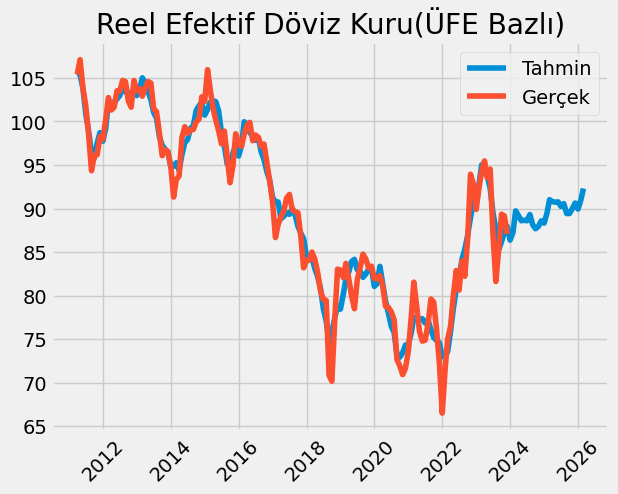

In [134]:
plt.title("Reel Efektif Döviz Kuru(ÜFE Bazlı)")
plt.plot(predictions["yhat"],label="Tahmin")
plt.plot(redk["REDK"],label="Gerçek")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [135]:
redktahmin=predictions["yhat"].tail(27)
redktahmin=pd.DataFrame(redktahmin)
redktahmin.columns=["REDK"]
redktahmin=redktahmin.set_index(pd.date_range(start="2023-12-31",periods=len(redkttahmin),freq="1M"))
redktahmin

,REDK
2023-12-31,86.373456
2024-01-31,87.239667
2024-02-29,89.729383
2024-03-31,89.170241
2024-04-30,88.597250
2024-05-31,88.653628
2024-06-30,88.593602
2024-07-31,89.307854
2024-08-31,88.121405
2024-09-30,87.675159


In [136]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin1["USD/TL"].rolling(3).mean(),paraarzitahmin1["Para Arzi"].shift(1),sanayitahmin1["Sanayi"],kreditahmin1.rolling(2).mean(),m3tahmin1.shift(1),borctahmin1.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin1["Enflasyon Belirsizliği"]
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Motorin"]=motorintahmin["Motorin"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["REDKT"]=redkttahmin["REDKT"]
tahmindf["REDK"]=redktahmin["REDK"]
#tahmindf["Politika Faizi"]=faiztahmin["Faiz"]
tahmindf["Perakende"]=perakendetahmin



tahmindf=tahmindf.iloc[:31]
tahmindf["Politika Faizi"]=[40,40,40,40,40,42.5,45,45,45,45,45,45,45,45,45,42.5,40,40,40,40,40,40,40,40,40,40,37.5,35,35,35]
tahmindf=tahmindf[['USD/TL', 'Motorin','Perakende', 'Kredi Faizi', 'Zam','Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','M3','REDKT','REDK','İşsizlik','Politika Faizi']]

tahmindf.columns=["USD/TL","Motorin","Perakende Satış","Kredi Faizi","Zam","Sanayi","Enflasyon Belirsizliği",'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','M3','REDKT','REDK','İşsizlik','Politika Faizi']
tahmindf=tahmindf.dropna(axis=0)





tahmindf.iloc[0,1]=-3.1847
#tahmindf.iloc[0,9]=2.675
tahmindf.iloc[-1,4]=25
tahmindf

,USD/TL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,M3,REDKT,REDK,İşsizlik,Politika Faizi
2023-12-31,2.499821,-3.184700,3.837414,59.690000,0.00,0.784145,3.360000,2.245991,4.034830,2.674319,52.600000,2.464258,55.124752,86.373456,8.454193,40.0
2024-01-31,2.182321,0.829570,2.255112,60.067635,49.11,0.790856,2.395268,3.398994,3.723207,2.895283,52.810984,3.639399,54.100201,87.239667,8.347127,42.5
2024-02-29,1.919193,2.514232,1.093496,60.199680,0.00,1.172986,2.705154,3.774062,2.973918,3.126431,50.932610,4.513183,54.903269,89.729383,8.364339,45.0
2024-03-31,2.047500,2.322167,2.545369,60.245852,0.00,-1.434704,2.729013,2.290557,3.622697,3.261061,52.414908,4.253471,55.120650,89.170241,8.439923,45.0
2024-04-30,2.137934,3.270154,-2.901185,60.261996,0.00,-2.033743,2.666159,3.675009,3.698124,3.864364,52.411042,3.763867,54.896201,88.597250,8.466738,45.0
2024-05-31,2.471129,2.729537,-2.657283,60.267641,0.00,1.259544,1.887541,3.591406,3.781603,3.737396,51.781859,5.587643,56.713874,88.653628,8.534691,45.0
2024-06-30,2.454019,2.165853,6.315988,60.269615,0.00,0.402223,1.270527,3.553608,3.941290,3.124587,52.124701,4.882602,56.546257,88.593602,8.602699,45.0
2024-07-31,2.265025,2.166142,1.493700,60.270305,0.00,0.576003,1.320320,2.745467,2.569477,2.972839,52.206740,2.400393,55.152070,89.307854,8.653981,45.0
2024-08-31,2.093244,1.875197,-0.782232,60.270546,0.00,0.456347,1.879789,2.972767,3.410054,2.913291,52.016242,3.626148,55.504813,88.121405,8.715422,45.0
2024-09-30,2.285641,2.180487,-1.221874,60.270631,0.00,0.778023,2.188238,2.746631,3.046820,2.481069,52.084607,4.013555,54.386131,87.675159,8.774888,45.0


In [137]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi']


In [138]:
df6.to_csv('df6.csv')

In [139]:
import keras
import keras.optimizers
prediction_list=[]
for i in range(10):
   keras.utils.set_random_seed(i)
   X = data.drop(['TÜFE'], axis=1).values
   y = data['TÜFE'].values
   X=data[features].values

   X_scaled = scaler.fit_transform(X)
   y_scaled = scaler.fit_transform(y.reshape(-1, 1))

   model = tf.keras.Sequential()
   model.add(tf.keras.layers.LSTM(128, activation='elu', input_shape=(9,1)))
   model.add(tf.keras.layers.Dense(64,activation='selu'))
   model.add(tf.keras.layers.Dense(64,activation='elu'))
   model.add(tf.keras.layers.Dense(1))
   rms = keras.optimizers.RMSprop(learning_rate=0.01)
   model.compile(optimizer=rms, loss='mean_squared_error')
   model.fit(X_scaled, y_scaled, epochs=100, batch_size=32)
   tahmin=tahmindf[features].values
   X_scaled = scaler.fit_transform(X)
   tahmin_scaled = scaler.transform(tahmin)
   pred = model.predict(tahmin_scaled)
   y_scaled = scaler.fit_transform(y.reshape(-1, 1))
   pred = scaler.inverse_transform(pred)
   prediction_list.append(pred)
columns = [f'Prediction_{i+1}' for i in range(10)]
predictions_df = pd.DataFrame(np.column_stack(prediction_list), columns=columns)

Epoch 1/100
4/4 [==============================] - 2s 12ms/step - loss: 6.7595
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0240
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.0196
Epoch 4/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0189
Epoch 5/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0177
Epoch 6/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0162
Epoch 7/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0179
Epoch 8/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0169
Epoch 9/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0846
Epoch 10/100
4/4 [==============================] - 0s 10ms/step - loss: 0.0186
Epoch 11/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0152
Epoch 12/100
4/4 [==============================] - 0s 11ms/step - loss: 0.0167
Epoch 13/100
4/4 [==============================]

In [140]:
pred=predictions_df.iloc[:,:11].mean(axis=1).values
pred

array([2.8988485, 4.43554  , 3.0092754, 3.0010269, 3.1748013, 3.0555043,
       2.925658 , 2.7497058, 2.8748665, 2.8671367, 2.7686994, 2.7108626,
       2.6564465, 3.4765553, 2.679229 , 2.6462915, 2.67324  , 2.6781623,
       2.6783535, 2.6728683, 2.6213825, 2.5356698, 2.4996915, 2.5076249,
       2.5179057, 3.1825857], dtype=float32)

In [141]:
corr=data.corr()["TÜFE"].sort_values(ascending=False)
np.abs(corr).sort_values(ascending=False)

TÜFE                      1.000000
USD/TL                    0.721865
Motorin                   0.713822
ParaArzi                  0.677832
M3                        0.669236
Enflasyon Belirsizliği    0.624443
REDKT                     0.578101
Kredi                     0.521249
Kredi Faizi               0.520287
Borç                      0.450264
Mevduat Faizi             0.423982
Zam                       0.407074
REDK                      0.388566
Politika Faizi            0.225434
İşsizlik                  0.194010
Perakende Satış           0.113209
Sanayi                    0.049493
Name: TÜFE, dtype: float64

In [142]:
tahmindf.columns

Index(['USD/TL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'M3', 'REDKT', 'REDK', 'İşsizlik', 'Politika Faizi'],
      dtype='object')

In [143]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT']


X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1806.50
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-12-30", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin1

,SGD Regressor
2023-12-31,1851.717039
2024-01-31,1947.043196
2024-02-29,2007.271583
2024-03-31,2065.636355
2024-04-30,2131.842906
2024-05-31,2197.762918
2024-06-30,2262.675675
2024-07-31,2326.211322
2024-08-31,2392.621833
2024-09-30,2462.634726


In [144]:
features=['USD/TL', 'Motorin',  'Kredi Faizi',  
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç','Kredi','Zam']






X= data[features]
y=data[["TÜFE"]]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1806.50
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-12-30", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin2


,Linear Regression
2023-12-31,1850.445042
2024-01-31,1942.425143
2024-02-29,2000.569923
2024-03-31,2056.760458
2024-04-30,2120.531635
2024-05-31,2183.708548
2024-06-30,2245.507961
2024-07-31,2305.203874
2024-08-31,2368.297174
2024-09-30,2434.913518


In [145]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi']





X = data[features]
reg = linear_model.Lasso(alpha=0.001)
reg.fit(X,y)


tüfetahmin5 = []
result = 1806.50
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-12-30", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin5

,Lasso Regression
2023-12-31,1850.307272
2024-01-31,1942.170123
2024-02-29,2000.275278
2024-03-31,2056.378401
2024-04-30,2120.062620
2024-05-31,2183.188366
2024-06-30,2244.890217
2024-07-31,2304.488132
2024-08-31,2367.476147
2024-09-30,2433.942798


In [146]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT']







X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1806.50
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-12-30", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin6


,Lars Regression
2023-12-31,1848.382281
2024-01-31,1938.582366
2024-02-29,1994.921624
2024-03-31,2048.910976
2024-04-30,2110.276820
2024-05-31,2170.995216
2024-06-30,2230.321879
2024-07-31,2287.877655
2024-08-31,2348.414356
2024-09-30,2412.437390


In [147]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDKT']




X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1806.50
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2023-12-30", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin7

,Kernel Regression
2023-12-31,1850.326013
2024-01-31,1942.698341
2024-02-29,2001.178725
2024-03-31,2057.543455
2024-04-30,2121.512999
2024-05-31,2185.020907
2024-06-30,2247.185005
2024-07-31,2307.494885
2024-08-31,2371.015505
2024-09-30,2438.032690


In [148]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT']





X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1806.50  
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin1),freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-12-31,1850.328645
2024-01-31,1942.705330
2024-02-29,2001.189274
2024-03-31,2057.558001
2024-04-30,2121.531868
2024-05-31,2185.044586
2024-06-30,2247.213654
2024-07-31,2307.528759
2024-08-31,2371.054627
2024-09-30,2438.076950


In [149]:
features=['USD/TL', 'Motorin',  'Kredi Faizi', 'Zam', 
       'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi',
       'M3', 'REDKT']

X = data[features]
y=data["TÜFE"]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1806.50 
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin1),freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-12-31,1853.554266
2024-01-31,1952.520955
2024-02-29,2016.878829
2024-03-31,2080.782948
2024-04-30,2150.938608
2024-05-31,2223.538189
2024-06-30,2294.702764
2024-07-31,2362.707668
2024-08-31,2434.944595
2024-09-30,2511.431377


In [150]:
pred1=pd.DataFrame(pred,index=pd.date_range(start="2023-12-30",periods=26,freq="1M"))
pred1=pred1[0]

In [151]:



tüfetahmin19 = []
result = 1806.50
lstmtahmin=pred1
for i in range(len(lstmtahmin)):
    result *= (1 + lstmtahmin[i] / 100)
    tüfetahmin19.append(result)

tüfetahmin19 = np.array(tüfetahmin19).reshape(-1, 1)
tüfetahmin19 = pd.DataFrame(tüfetahmin19)
tüfetahmin19.columns = ["LSTM"]
tüfetahmin19 = tüfetahmin19.set_index(pd.date_range(start="2023-12-30", end="2026-02-27", freq="1M"))
tüfetahmin19

,LSTM
2023-12-31,1858.867699
2024-01-31,1941.318523
2024-02-29,1999.738144
2024-03-31,2059.750823
2024-04-30,2125.143820
2024-05-31,2190.077681
2024-06-30,2254.151864
2024-07-31,2316.134408
2024-08-31,2382.720180
2024-09-30,2451.036025


In [152]:
features=['USD/TL', 'Motorin',  'Zam', 'Enflasyon Belirsizliği', 'ParaArzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDKT']
X = data[features]
y=data[["TÜFE"]]
model = sm.RLM(y, X, M=sm.robust.norms.HuberT())
# Modeli uydurun
results = model.fit()

robusttahmin=results.predict(tahmindf[features])

tüfetahmin21 = []
result = 1806.50
for i in range(len(robusttahmin)):
    result *= (1 + robusttahmin[i] / 100)
    tüfetahmin21.append(result)

tüfetahmin21 = np.array(tüfetahmin21).reshape(-1, 1)
tüfetahmin21 = pd.DataFrame(tüfetahmin21)
tüfetahmin21.columns = ["Robust Regression"]
tüfetahmin21 = tüfetahmin21.set_index(pd.date_range(start="2023-12-30", periods=len(tüfetahmin1), freq="1M"))
tüfetahmin21

,Robust Regression
2023-12-31,1856.685332
2024-01-31,1961.860549
2024-02-29,2024.435052
2024-03-31,2085.811137
2024-04-30,2153.888850
2024-05-31,2220.400119
2024-06-30,2285.989466
2024-07-31,2352.272973
2024-08-31,2421.452142
2024-09-30,2495.573293


In [153]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["LSTM"]=tüfetahmin19["LSTM"]
tüfetahmin["Robust Regression"]=tüfetahmin21["Robust Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,LSTM,Robust Regression,Ortalama
2023-12-31,1851.717039,1850.445042,1850.307272,1848.382281,1850.326013,1850.328645,1853.554266,1858.867699,1856.685332,1852.290399
2024-01-31,1947.043196,1942.425143,1942.170123,1938.582366,1942.698341,1942.705330,1952.520955,1941.318523,1961.860549,1945.702725
2024-02-29,2007.271583,2000.569923,2000.275278,1994.921624,2001.178725,2001.189274,2016.878829,1999.738144,2024.435052,2005.162048
2024-03-31,2065.636355,2056.760458,2056.378401,2048.910976,2057.543455,2057.558001,2080.782948,2059.750823,2085.811137,2063.236951
2024-04-30,2131.842906,2120.531635,2120.062620,2110.276820,2121.512999,2121.531868,2150.938608,2125.143820,2153.888850,2128.414459
2024-05-31,2197.762918,2183.708548,2183.188366,2170.995216,2185.020907,2185.044586,2223.538189,2190.077681,2220.400119,2193.304059
2024-06-30,2262.675675,2245.507961,2244.890217,2230.321879,2247.185005,2247.213654,2294.702764,2254.151864,2285.989466,2256.959832
2024-07-31,2326.211322,2305.203874,2304.488132,2287.877655,2307.494885,2307.528759,2362.707668,2316.134408,2352.272973,2318.879964
2024-08-31,2392.621833,2368.297174,2367.476147,2348.414356,2371.015505,2371.054627,2434.944595,2382.720180,2421.452142,2384.221840
2024-09-30,2462.634726,2434.913518,2433.942798,2412.437390,2438.032690,2438.076950,2511.431377,2451.036025,2495.573293,2453.119863


In [154]:
dates=pd.date_range('2006-02-01','2023-12-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9,dfas10],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








In [155]:
row=pd.DataFrame({"SGD Regressor":df.iloc[-1,0],"Lasso Regression":df.iloc[-1,0],"Lars Regression":df.iloc[-1,0],"Gaussian Regression":df.iloc[-1,0],"Kernel Regression":df.iloc[-1,0],"Bayessian Regression":df.iloc[-1,0],"Linear Regression":df.iloc[-1,0],"LSTM":df.iloc[-1,0],"Robust Regression":df.iloc[-1,0],"Ortalama":df.iloc[-1,0]},index=pd.date_range(start="2023-11-30",periods=1,freq="1M"))
tüfetahmin=pd.concat([row,tüfetahmin],axis=0)
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
tüfetahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Ortalama
2023-11-30,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000,1806.500000
2023-12-31,1851.717039,1850.307272,1848.382281,1850.328645,1850.326013,1853.554266,1850.445042,1858.867699,1856.685332,1852.290399
2024-01-31,1947.043196,1942.170123,1938.582366,1942.705330,1942.698341,1952.520955,1942.425143,1941.318523,1961.860549,1945.702725
2024-02-29,2007.271583,2000.275278,1994.921624,2001.189274,2001.178725,2016.878829,2000.569923,1999.738144,2024.435052,2005.162048
2024-03-31,2065.636355,2056.378401,2048.910976,2057.558001,2057.543455,2080.782948,2056.760458,2059.750823,2085.811137,2063.236951
2024-04-30,2131.842906,2120.062620,2110.276820,2121.531868,2121.512999,2150.938608,2120.531635,2125.143820,2153.888850,2128.414459
2024-05-31,2197.762918,2183.188366,2170.995216,2185.044586,2185.020907,2223.538189,2183.708548,2190.077681,2220.400119,2193.304059
2024-06-30,2262.675675,2244.890217,2230.321879,2247.213654,2247.185005,2294.702764,2245.507961,2254.151864,2285.989466,2256.959832
2024-07-31,2326.211322,2304.488132,2287.877655,2307.528759,2307.494885,2362.707668,2305.203874,2316.134408,2352.272973,2318.879964
2024-08-31,2392.621833,2367.476147,2348.414356,2371.054627,2371.015505,2434.944595,2368.297174,2382.720180,2421.452142,2384.221840


In [156]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
aylıktahmin.iloc[0,:]=aylıktahmin.iloc[0,:]+0.33
aylıktahmin.iloc[5,:]=aylıktahmin.iloc[5,:]+0.50
aylıktahmin

,SGD Regressor,Lasso Regression,Lars Regression,Gaussian Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Ortalama
2023-12-31,2.833019,2.754980,2.648421,2.756164,2.756018,2.934720,2.762607,3.228849,3.108042,2.864758
2024-01-31,5.147987,4.964735,4.879947,4.992447,4.992219,5.339293,4.970702,4.435540,5.664676,5.043071
2024-02-29,3.093326,2.991764,2.906209,3.010438,3.010266,3.296143,2.993412,3.009275,3.189549,3.055930
2024-03-31,2.907667,2.804770,2.706339,2.816761,2.816577,3.168466,2.808726,3.001027,3.031764,2.896270
2024-04-30,3.205141,3.096911,2.995047,3.109213,3.109025,3.371599,3.100564,3.174801,3.263848,3.158993
2024-05-31,3.592161,3.477542,3.377272,3.493720,3.493520,3.875251,3.479296,3.555504,3.587962,3.548730
2024-06-30,2.953583,2.826227,2.732694,2.845208,2.845012,3.200511,2.830021,2.925658,2.953943,2.902278
2024-07-31,2.807987,2.654825,2.580604,2.683995,2.683797,2.963560,2.658459,2.749706,2.899554,2.743519
2024-08-31,2.854879,2.733276,2.645976,2.752983,2.752796,3.057379,2.736994,2.874866,2.940950,2.817821
2024-09-30,2.926200,2.807490,2.726224,2.826688,2.826518,3.141212,2.812837,2.867137,3.061021,2.889749


In [233]:
aralık=[aylıktahmin.iloc[0,:].sort_values(ascending=True)]
aralık=pd.DataFrame(aralık)
aralık=aralık.reset_index()
aralık

,index,Lars Regression,Lasso Regression,Kernel Regression,Gaussian Regression,Linear Regression,SGD Regressor,Ortalama,Bayessian Regression,Robust Regression,LSTM
0,2023-12-31,2.648421,2.75498,2.756018,2.756164,2.762607,2.833019,2.864758,2.93472,3.108042,3.228849


In [276]:
aralık.iloc[0,1:]

Lars Regression         2.648421
Lasso Regression         2.75498
Kernel Regression       2.756018
Gaussian Regression     2.756164
Linear Regression       2.762607
SGD Regressor           2.833019
Ortalama                2.864758
Bayessian Regression     2.93472
Robust Regression       3.108042
LSTM                    3.228849
Name: 0, dtype: object

In [334]:
dff2=pd.DataFrame({"Foreks Haber":43.18,"Bloomberg":42,"AA Finans":42.39,"AI Inflation Forecast":44.51,"Piyasa Katılımcıları Anketi":41.23,"TCMB":36.0},index=pd.date_range(start="2023-12-31",periods=1,freq="1M"))
dff2=dff2.iloc[0,:].sort_values(ascending=True)
dff2=pd.DataFrame(dff2)
dff2.iloc[:,0]

TCMB                           36.00
Piyasa Katılımcıları Anketi    41.23
Bloomberg                      42.00
AA Finans                      42.39
Foreks Haber                   43.18
AI Inflation Forecast          44.51
Name: 2023-12-31 00:00:00, dtype: float64

In [342]:
np.arange(0,50,5)

array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45])

Text(0.5, 1.0, '2024 Sonu Enflasyon Tahminleri')

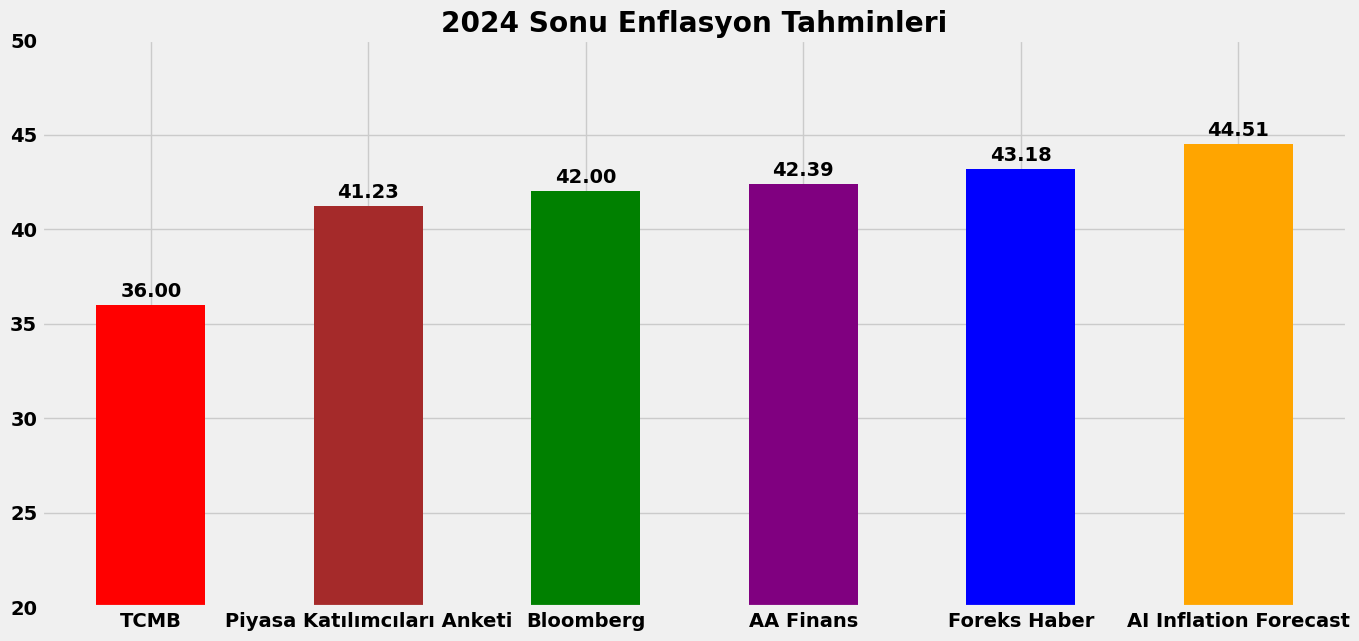

In [347]:
plt.style.use('fivethirtyeight')
renkler = ['red',"brown", 'green',  'purple',"blue","orange"]
ax=dff2.iloc[:,0].plot.bar(figsize=(15,7),rot=0,color=renkler)
plt.ylim(20,50)
plt.yticks(color="black",fontweight="bold")
plt.xticks(color="black",fontweight="bold")
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black',fontweight="bold")
plt.title("2024 Sonu Enflasyon Tahminleri",fontweight="bold",color="black")

In [366]:
dff1=pd.DataFrame({"Foreks Haber":3.0,"Reuters":3.1,"Bloomberg":3.12,"AA Finans":3.19,"AI Inflation Forecast":2.85,"TCMB Anketi":3.26},index=pd.date_range(start="2023-12-31",periods=1,freq="1M"))
dff1=dff1.iloc[0,:].sort_values(ascending=True)
dff1=pd.DataFrame(dff1)
dff1.iloc[:,0]

AI Inflation Forecast    2.85
Foreks Haber             3.00
Reuters                  3.10
Bloomberg                3.12
AA Finans                3.19
TCMB Anketi              3.26
Name: 2023-12-31 00:00:00, dtype: float64

Text(0.5, 1.0, 'Aralık Ayı Enflasyon Tahminleri')

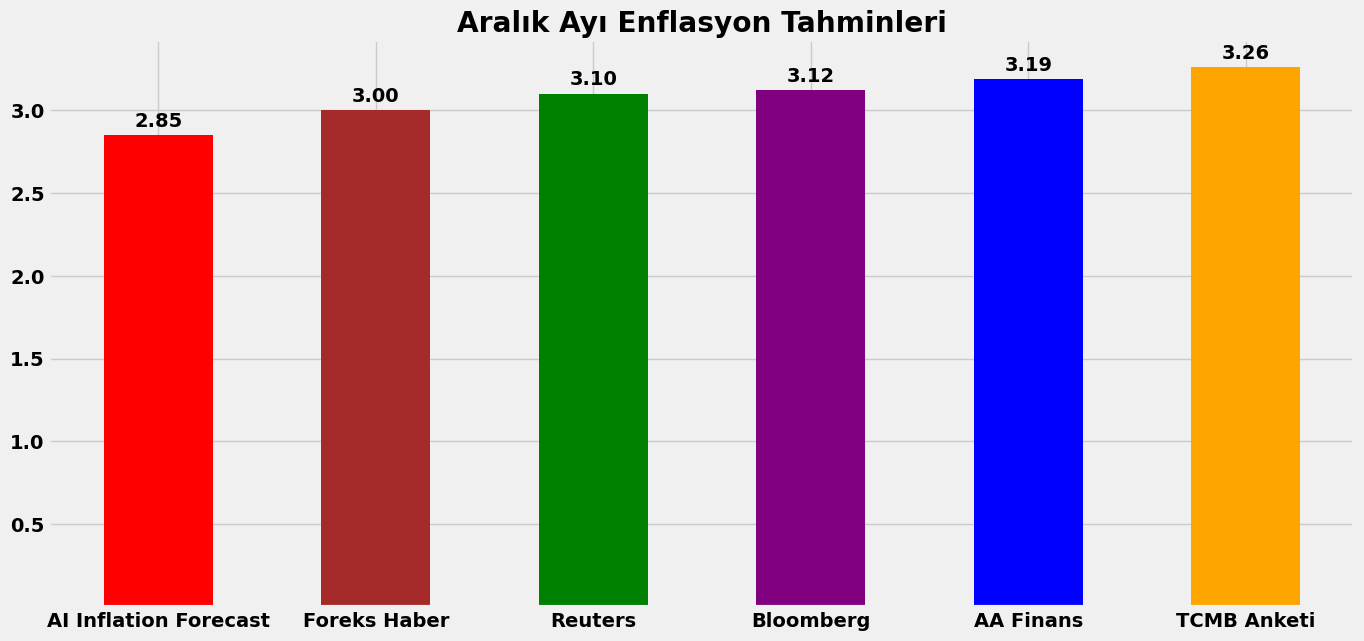

In [368]:
plt.style.use('fivethirtyeight')
renkler = ['red',"brown", 'green',  'purple',"blue","orange"]
ax=dff1.iloc[:,0].plot.bar(figsize=(15,7),rot=0,color=renkler)
plt.yticks(color="black",fontweight="bold",ticks=np.arange(0.5,3.5,0.5))
plt.xticks(color="black",fontweight="bold")
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black',fontweight="bold")
plt.title("Aralık Ayı Enflasyon Tahminleri",fontweight="bold",color="black")


In [349]:
dff3=pd.DataFrame({"Foreks Haber":3.5,"Reuters":3.9,"Bloomberg":3.8,"AA Finans":3.68,"AI Inflation Forecast":3.38,"TÜFE":3.28},index=pd.date_range(start="2023-11-30",periods=1,freq="1M"))
dff3=dff3.iloc[0,:].sort_values(ascending=True)
dff3=pd.DataFrame(dff3)
dff3.iloc[:,0]

TÜFE                     3.28
AI Inflation Forecast    3.38
Foreks Haber             3.50
AA Finans                3.68
Bloomberg                3.80
Reuters                  3.90
Name: 2023-11-30 00:00:00, dtype: float64

Text(0.5, 1.0, 'Kasım Ayı Enflasyon Tahminleri')

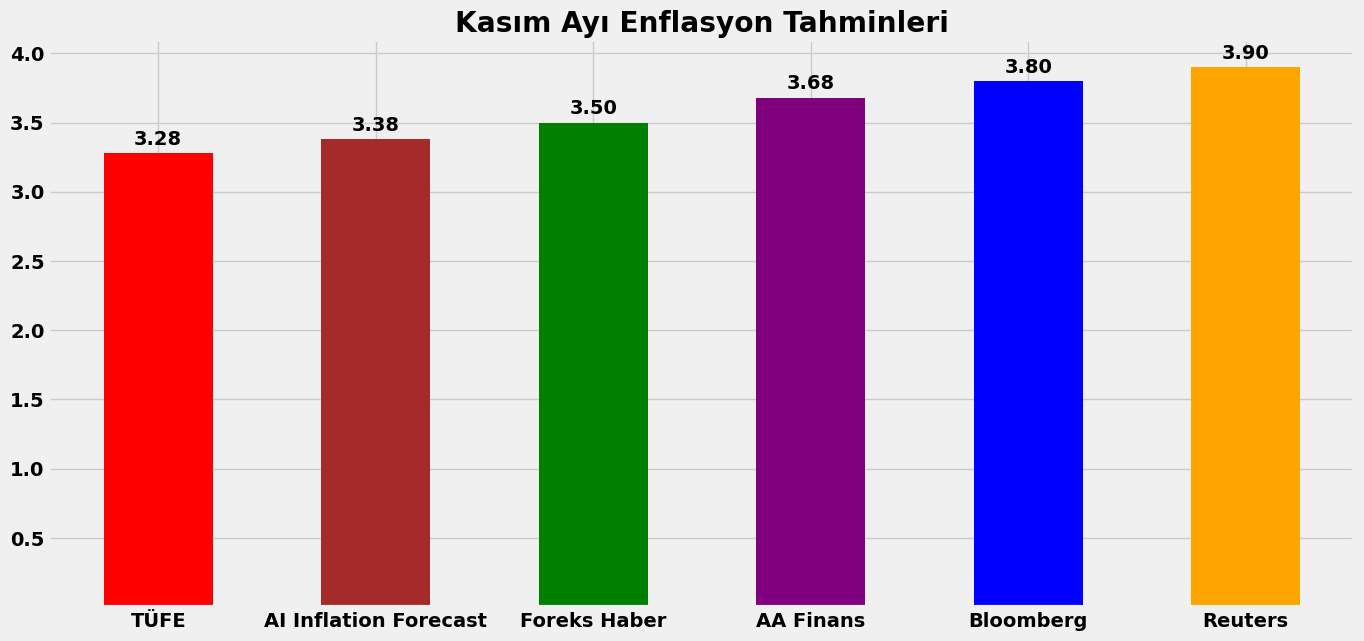

In [357]:
plt.style.use('fivethirtyeight')
renkler = ['red',"brown", 'green',  'purple',"blue","orange"]
ax=dff3.iloc[:,0].plot.bar(figsize=(15,7),rot=0,color=renkler)
plt.yticks(color="black",fontweight="bold",ticks=np.arange(0.5,4.5,0.5))
plt.xticks(color="black",fontweight="bold")

for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black',fontweight="bold")
plt.title("Kasım Ayı Enflasyon Tahminleri",fontweight="bold",color="black")

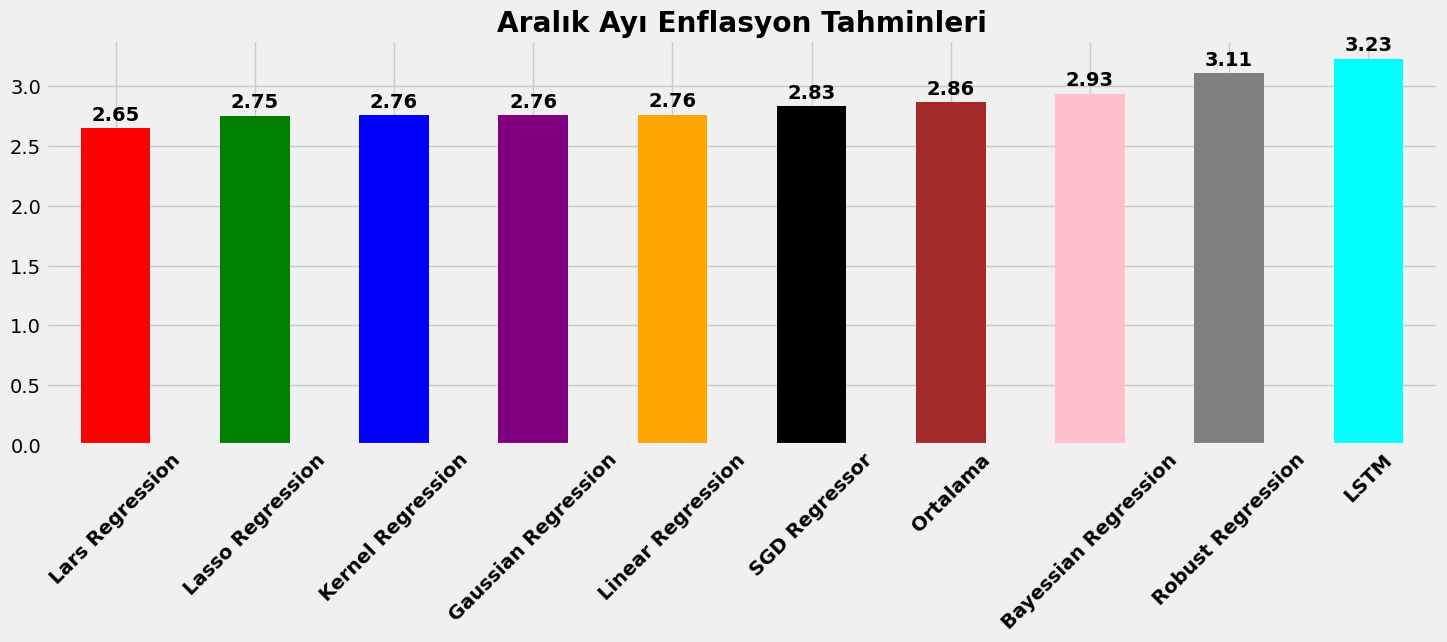

In [260]:
from matplotlib import cm
plt.style.use('fivethirtyeight')
renkler = ['red', 'green', 'blue', 'purple', 'orange', 'black', 'brown', 'pink', 'gray', 'cyan']
ax=aralık.iloc[0,1:].plot.bar(figsize=(16,5),rot=45,color=renkler)
ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold',color="black")
for p in ax.patches:
    ax.annotate('{:.2f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', color='black',fontweight="bold")
plt.title("Aralık Ayı Enflasyon Tahminleri",fontweight="bold",color="black")
plt.yticks(color="black")
plt.show()


In [157]:
aylıktahmin.to_csv('modelaylık.csv')

In [158]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
orttahmin=aylıktahmin["Ortalama"]
orttahmin=1+(orttahmin/100)
for elem in orttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin10),freq="1M"))
tüfetahmin10.columns=["CPI"]

tüfetahmin11=pd.concat([df["CPI"],tüfetahmin10["CPI"]],axis=0)
tüfetahmin11=pd.DataFrame((tüfetahmin11.pct_change(periods=12)*100).tail(38))

    

In [159]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin12 = []
krrtahmin=aylıktahmin["Gaussian Regression"]
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin12.append(tüfe)
tüfetahmin12=pd.DataFrame(tüfetahmin12)
tüfetahmin12=tüfetahmin12.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin12),freq="1M"))
tüfetahmin12.columns=["CPI"]
tüfetahmin12=pd.concat([df["CPI"],tüfetahmin12["CPI"]],axis=0)
tüfetahmin12=pd.DataFrame((tüfetahmin12.pct_change(periods=12)*100).tail(38))


In [160]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin13 = []
bayestahmin=aylıktahmin["SGD Regressor"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin13.append(tüfe)
tüfetahmin13=pd.DataFrame(tüfetahmin13)
tüfetahmin13=tüfetahmin13.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin13),freq="1M"))
tüfetahmin13.columns=["CPI"]
tüfetahmin13=pd.concat([df["CPI"],tüfetahmin13["CPI"]],axis=0)
tüfetahmin13=pd.DataFrame((tüfetahmin13.pct_change(periods=12)*100).tail(38))


In [161]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin14 = []
lassotahmin=aylıktahmin["Lasso Regression"]
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin14.append(tüfe)
tüfetahmin14=pd.DataFrame(tüfetahmin14)
tüfetahmin14=tüfetahmin14.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin14),freq="1M"))
tüfetahmin14.columns=["CPI"]
tüfetahmin14=pd.concat([df["CPI"],tüfetahmin14["CPI"]],axis=0)
tüfetahmin14=pd.DataFrame((tüfetahmin14.pct_change(periods=12)*100).tail(38))


In [162]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin15 = []
larstahmin=aylıktahmin["Lars Regression"]
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin15.append(tüfe)
tüfetahmin15=pd.DataFrame(tüfetahmin15)
tüfetahmin15=tüfetahmin15.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin15),freq="1M"))
tüfetahmin15.columns=["CPI"]
tüfetahmin15=pd.concat([df["CPI"],tüfetahmin15["CPI"]],axis=0)
tüfetahmin15=pd.DataFrame((tüfetahmin15.pct_change(periods=12)*100).tail(38))


In [163]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin16 = []
kerneltahmin=aylıktahmin["Kernel Regression"]
kerneltahmin=1+(kerneltahmin/100)
for elem in kerneltahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin16.append(tüfe)
tüfetahmin16=pd.DataFrame(tüfetahmin16)
tüfetahmin16=tüfetahmin16.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin16),freq="1M"))
tüfetahmin16.columns=["CPI"]
tüfetahmin16=pd.concat([df["CPI"],tüfetahmin16["CPI"]],axis=0)
tüfetahmin16=pd.DataFrame((tüfetahmin16.pct_change(periods=12)*100).tail(38))

In [164]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin17 = []
bayestahmin=aylıktahmin["Bayessian Regression"]
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin17.append(tüfe)
tüfetahmin17=pd.DataFrame(tüfetahmin17)
tüfetahmin17=tüfetahmin17.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin17),freq="1M"))
tüfetahmin17.columns=["CPI"]
tüfetahmin17=pd.concat([df["CPI"],tüfetahmin17["CPI"]],axis=0)
tüfetahmin17=pd.DataFrame((tüfetahmin17.pct_change(periods=12)*100).tail(38))

In [165]:
tüfe = 1806.50# İlk değeri 1691 ile başlatıyoruz
tüfetahmin18 = []
lineartahmin=aylıktahmin["Linear Regression"]
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin18.append(tüfe)
tüfetahmin18=pd.DataFrame(tüfetahmin18)
tüfetahmin18=tüfetahmin18.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin18),freq="1M"))
tüfetahmin18.columns=["CPI"]
tüfetahmin18=pd.concat([df["CPI"],tüfetahmin18["CPI"]],axis=0)
tüfetahmin18=pd.DataFrame((tüfetahmin18.pct_change(periods=12)*100).tail(38))


In [166]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin20 = []
lstmtahmin=aylıktahmin["LSTM"]
lstmtahmin=1+(lstmtahmin/100)
for elem in lstmtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin20.append(tüfe)
tüfetahmin20=pd.DataFrame(tüfetahmin20)
tüfetahmin20=tüfetahmin20.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin20),freq="1M"))
tüfetahmin20.columns=["CPI"]
tüfetahmin20=pd.concat([df["CPI"],tüfetahmin20["CPI"]],axis=0)
tüfetahmin20=pd.DataFrame((tüfetahmin20.pct_change(periods=12)*100).tail(38))

In [167]:
tüfe = 1806.50 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin22 = []
robusttahmin=aylıktahmin["Robust Regression"]
robusttahmin=1+(robusttahmin/100)
for elem in robusttahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin22.append(tüfe)
tüfetahmin22=pd.DataFrame(tüfetahmin22)
tüfetahmin22=tüfetahmin22.set_index(pd.date_range(start="2023-12-30",periods=len(tüfetahmin22),freq="1M"))
tüfetahmin22.columns=["CPI"]
tüfetahmin22=pd.concat([df["CPI"],tüfetahmin22["CPI"]],axis=0)
tüfetahmin22=pd.DataFrame((tüfetahmin22.pct_change(periods=12)*100).tail(38))


In [168]:
aylık=data["TÜFE"]
aylık=pd.DataFrame(aylık)
ekim=pd.DataFrame({"TÜFE":3.43},index=pd.date_range(start="2023-10-30",periods=1,freq="1M"))
aylık=pd.concat([aylık,ekim],axis=0)

In [169]:
aylık1=aylıktahmin
aylık1=aylık1[["Ortalama"]]
aylık1.columns=["TÜFE"]
aylık1=pd.concat([aylık["TÜFE"],aylık1["TÜFE"]])
aylık1=pd.DataFrame(aylık1)
#aylık1=aylık1.set_index(pd.date_range(start="2014-01-30",end="2025-02-27",freq="1M"))
aylık1.head(132).to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/aylık.csv')

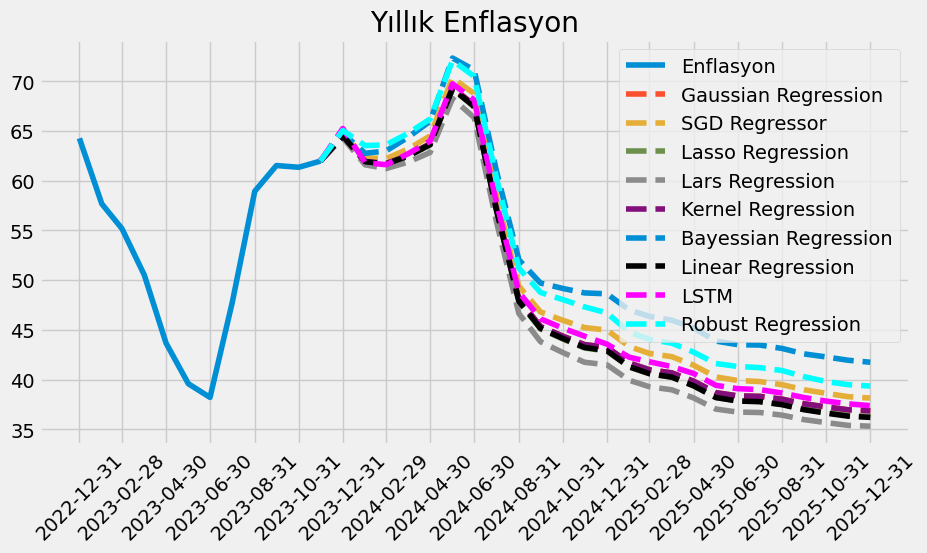

In [170]:
yıllıktahmin=pd.DataFrame()
yıllıktahmin["Ortalama"]=tüfetahmin11["CPI"]
yıllıktahmin["SGD Regressor"]=tüfetahmin13["CPI"]
yıllıktahmin["Gaussian Regression"]=tüfetahmin12["CPI"]
yıllıktahmin["Lasso Regression"]=tüfetahmin14["CPI"]
yıllıktahmin["Lars Regression"]=tüfetahmin15["CPI"]
yıllıktahmin["Kernel Regression"]=tüfetahmin16["CPI"]
yıllıktahmin["Bayessian Regression"]=tüfetahmin17["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["Linear Regression"]=tüfetahmin18["CPI"]
yıllıktahmin["LSTM"]=tüfetahmin20["CPI"]
yıllıktahmin["Robust Regression"]=tüfetahmin22["CPI"]
plt.figure(figsize=(10,5))
plt.plot(yıllıktahmin["Ortalama"].iloc[:12],label="Enflasyon")
plt.plot(yıllıktahmin["Gaussian Regression"].iloc[11:-1],'--',label="Gaussian Regression")
plt.plot(yıllıktahmin["SGD Regressor"].iloc[11:-1],'--',label="SGD Regressor")
plt.plot(yıllıktahmin["Lasso Regression"].iloc[11:-1],'--',label="Lasso Regression")
plt.plot(yıllıktahmin["Lars Regression"].iloc[11:-1],'--',label="Lars Regression")
plt.plot(yıllıktahmin["Kernel Regression"].iloc[11:-1],'--',label="Kernel Regression")
plt.plot(yıllıktahmin["Bayessian Regression"].iloc[11:-1],'--',label="Bayessian Regression")
plt.plot(yıllıktahmin["Linear Regression"].iloc[11:-1],'--',label="Linear Regression",color="black")
plt.plot(yıllıktahmin["LSTM"].iloc[11:-1],'--',label="LSTM",color="magenta")
plt.plot(yıllıktahmin["Robust Regression"].iloc[11:-1],'--',label="Robust Regression",color="cyan")
plt.legend(loc=0)
plt.xticks(rotation=45)
plt.xticks(pd.date_range(start="2022-12-30",end="2026-02-27",freq="1M")[::2])
plt.title("Yıllık Enflasyon")
plt.show()

In [171]:

df.to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/df.csv')

In [172]:
yıllıktahmin["Maksimum"]=yıllıktahmin.iloc[:,1:11].max(axis=1)
yıllıktahmin["Minimum"]=yıllıktahmin.iloc[:,1:11].min(axis=1)
yıllıktahmin["Ortalama"]=yıllıktahmin.iloc[:,1:11].mean(axis=1)
yıllıktahmin["Medyan"]=yıllıktahmin.iloc[:,1:11].median(axis=1)
yıllıktahmin.iloc[:-13].to_csv('C:/Users/Bora/Documents/GitHub/streamlit-inflation/yıllıktahmin.csv')
yıllıktahmin


,Ortalama,SGD Regressor,Gaussian Regression,Lasso Regression,Lars Regression,Kernel Regression,Bayessian Regression,Linear Regression,LSTM,Robust Regression,Maksimum,Minimum,Medyan
2022-12-31,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597,64.269597
2023-01-31,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481,57.682481
2023-02-28,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828,55.179828
2023-03-31,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511,50.508511
2023-04-30,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170,43.684170
2023-05-31,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301,39.585301
2023-06-30,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519,38.213519
2023-07-31,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733,47.831733
2023-08-31,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534,58.943534
2023-09-30,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865


In [173]:
sonu2023=str(yıllıktahmin.iloc[12,0])[:5]
tepe=str(yıllıktahmin.iloc[17,0])[:5]
sonu2024=str(yıllıktahmin.iloc[24,0])[:5]
max=str(yıllıktahmin.iloc[-2,-3])[:5]
min=str(yıllıktahmin.iloc[-2,-2])[:5]
sonu2025=str(yıllıktahmin.iloc[36,0])[:5]

In [174]:
min1=str(yıllıktahmin.iloc[24,-2])[:2]
max1=str(yıllıktahmin.iloc[24,-3])[:2]

In [175]:
min1

'41'

In [176]:
df.iloc[-25:,0].shift(12).dropna()

2022-11-30     604.84
2022-12-31     686.95
2023-01-31     763.23
2023-02-28     799.93
2023-03-31     843.64
2023-04-30     904.79
2023-05-31     931.76
2023-06-30     977.90
2023-07-31    1001.03
2023-08-31    1015.65
2023-09-30    1046.89
2023-10-31    1084.00
2023-11-30    1115.26
Freq: M, Name: CPI, dtype: float64

In [177]:
cariay=evds.get_data(["TP.BEK.S01.A.U"],startdate="01-11-2022",enddate="31-12-2023")
cariay=cariay.set_index(pd.date_range(start="2022-11-30",periods=14,freq="1M"))
del cariay["Tarih"]
cariay.columns=["Cari Ay Medyan Tahmin"]
cariay["TÜFE"]=df.iloc[-14:,0].shift(1).dropna()
cariay["Cari Ay Medyan Tahmin"]=1+(cariay["Cari Ay Medyan Tahmin"]/100)
cariay.iloc[-1,1]=1806.50
cariay["Enflasyon"]=cariay["Cari Ay Medyan Tahmin"]*cariay["TÜFE"]
cariay["TÜFE Önceki"]=df.iloc[-25:,0].shift(12).dropna()
cariay.iloc[-1,3]=1128.45
cariay["Enflasyon"]=((cariay["Enflasyon"]/cariay["TÜFE Önceki"])-1)*100
cariay

,Cari Ay Medyan Tahmin,TÜFE,Enflasyon,TÜFE Önceki
2022-11-30,1.0314,1084.00,84.848489,604.84
2022-12-31,1.0269,1115.26,66.716718,686.95
2023-01-31,1.0265,1128.45,51.769968,763.23
2023-02-28,1.0301,1203.48,54.976654,799.93
2023-03-31,1.0288,1241.33,51.377401,843.64
2023-04-30,1.0265,1269.75,44.055347,904.79
2023-05-31,1.0241,1300.04,42.887757,931.76
2023-06-30,1.0281,1300.60,36.736564,977.90
2023-07-31,1.0376,1351.59,40.096679,1001.03
2023-08-31,1.0554,1479.84,53.775724,1015.65


In [178]:
ay1sonra=evds.get_data(["TP.BEK.S01.B.U"],startdate="01-12-2023",enddate="31-12-2023")
ay1sonra["TÜFE"]=1866.34
ay1sonra["TÜFE Yeni"]=(1+(ay1sonra["TP_BEK_S01_B_U"]/100))*ay1sonra["TÜFE"]
ay1sonra["TÜFE Eski"]=df.loc["2023-01-31"]["CPI"]
ay1sonra["Enflasyon"]=((ay1sonra["TÜFE Yeni"]/ay1sonra["TÜFE Eski"])-1)*100
ay1sonra

,Tarih,TP_BEK_S01_B_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2023-12,4.86,1866.34,1957.044124,1203.48,62.615426


In [179]:
ay2sonra=evds.get_data(["TP.BEK.S01.C.U"],startdate="01-12-2023",enddate="31-12-2023")
ay2sonra["TÜFE"]=ay1sonra["TÜFE Yeni"]
ay2sonra["TÜFE Yeni"]=(1+(ay2sonra["TP_BEK_S01_C_U"]/100))*ay2sonra["TÜFE"]
ay2sonra["TÜFE Eski"]=df.loc["2023-02-28"]["CPI"]
ay2sonra["Enflasyon"]=((ay2sonra["TÜFE Yeni"]/ay2sonra["TÜFE Eski"])-1)*100
ay2sonra

,Tarih,TP_BEK_S01_C_U,TÜFE,TÜFE Yeni,TÜFE Eski,Enflasyon
0,2023-12,3.25,1957.044124,2020.648058,1241.33,62.780893


In [180]:
ay12sonra=evds.get_data(["TP.BEK.S01.E.U"],startdate="01-12-2023",enddate="31-12-2023")
ay12sonra.columns=["Tarih","12 Ay Sonrası"]
ay12sonra

,Tarih,12 Ay Sonrası
0,2023-12,41.23


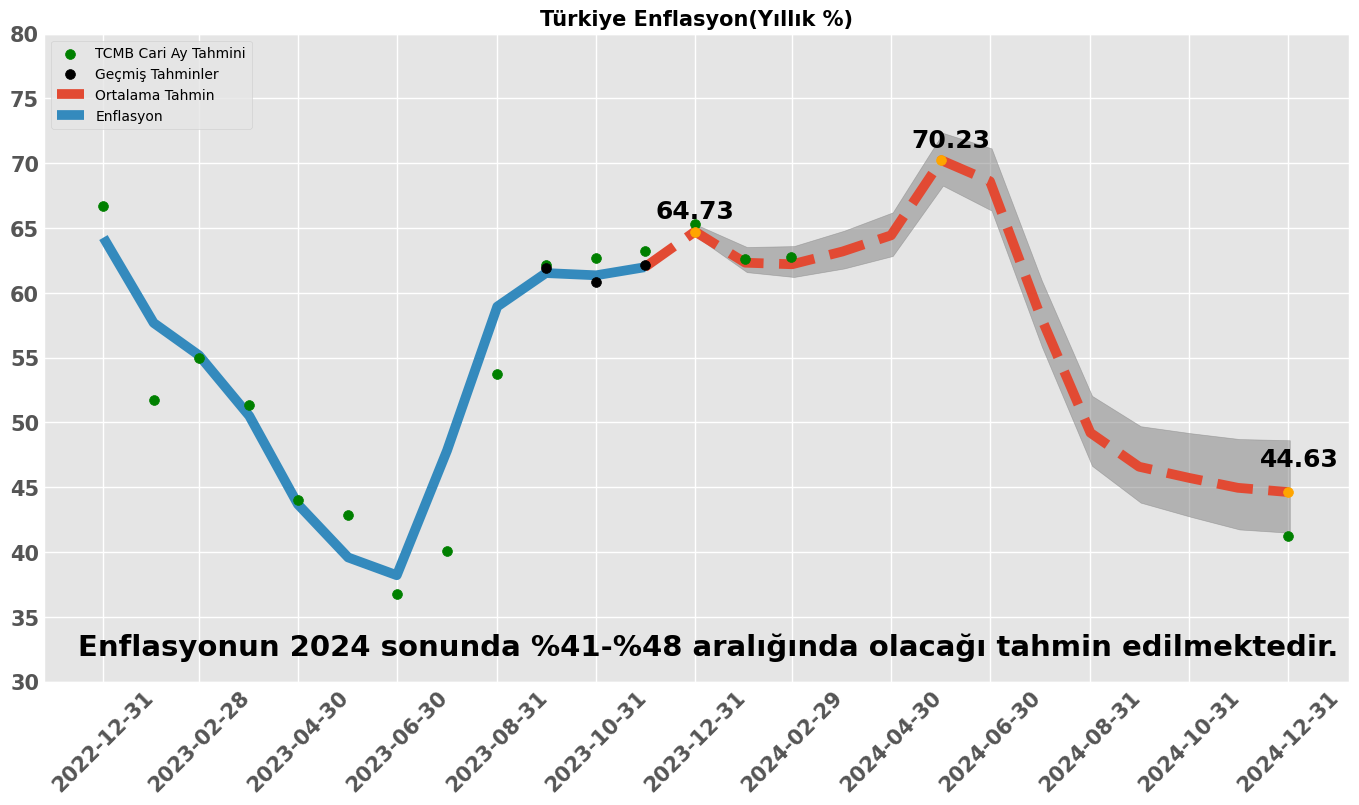

In [181]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('ggplot')
fig=plt.figure(figsize=(15,8))
plt.scatter(x=pd.to_datetime("2024-01-31"),y=ay1sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=pd.to_datetime("2024-02-28"),y=ay2sonra["Enflasyon"],color="green",zorder=3,s=50)
plt.scatter(x=cariay[1:].index,y=cariay["Enflasyon"][1:].values,color="green",zorder=3,label='TCMB Cari Ay Tahmini',s=50)
plt.scatter(x=pd.to_datetime("2024-12-31"),y=ay12sonra["12 Ay Sonrası"].values,color="green",zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[9:12],y=[61.94,60.84,62.13],color='black',zorder=3,label='Geçmiş Tahminler',s=50)
plt.scatter(x=yıllıktahmin.index[12],y=yıllıktahmin.iloc[12,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[17],y=yıllıktahmin.iloc[17,0],color='orange',zorder=3,s=50)
plt.scatter(x=yıllıktahmin.index[24],y=yıllıktahmin.iloc[24,0],color='orange',zorder=3,s=50)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
#plt.scatter(x=yıllıktahmin.index[36],y=yıllıktahmin.iloc[36,0],color='orange',zorder=3,s=50)
plt.plot(yıllıktahmin["Ortalama"].iloc[11:25],'--',label="Ortalama Tahmin",linewidth=7)
plt.plot(yıllıktahmin["Ortalama"].iloc[:12],label="Enflasyon",linewidth=7)
plt.fill_between(yıllıktahmin.iloc[12:26].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[12:26].shift(1), yıllıktahmin["Minimum"].iloc[12:26].shift(1), alpha=0.5, color='gray')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2025-01')
plt.text(mdates.datestr2num('2023-12'), float(sonu2023)+1, sonu2023, fontsize=18, color='black', horizontalalignment='center',fontweight='bold')
plt.text(mdates.datestr2num('2024-06'), float(tepe)+1, tepe, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
plt.text(mdates.datestr2num('2025-01'), float(sonu2024)+2, sonu2024, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2026-01'), float(sonu2024)-5, sonu2025, fontsize=18, color='black', horizontalalignment='right',fontweight='bold')
#plt.text(mdates.datestr2num('2025-12'), float(sonra24ay)+3, sonra24ay, fontsize=12, color='black', horizontalalignment='right',fontweight='bold')

plt.text(annotation_date, 32, f"Enflasyonun 2024 sonunda %{min1}-%{max1} aralığında olacağı tahmin edilmektedir.", fontsize=21, color='black', horizontalalignment='right',fontweight='bold')
plt.xticks(yıllıktahmin.index[:26:2],rotation=45,fontsize=15,fontweight="bold")
plt.yticks(np.arange(30,85,5),fontsize=15,fontweight="bold")
plt.title("Türkiye Enflasyon(Yıllık %)",fontsize=15,fontweight="bold")
plt.legend(loc=2)
plt.savefig('forecast.png')
plt.savefig("./forecasts/"+date.today().strftime("%d-%m-%Y")+'.png')
plt.show()


In [182]:
yıllıktahmin.index[:26:2]

DatetimeIndex(['2022-12-31', '2023-02-28', '2023-04-30', '2023-06-30',
               '2023-08-31', '2023-10-31', '2023-12-31', '2024-02-29',
               '2024-04-30', '2024-06-30', '2024-08-31', '2024-10-31',
               '2024-12-31'],
              dtype='datetime64[ns]', freq='2M')

(array([0, 1, 2]),
 [Text(0, 0, '2023-09'), Text(1, 0, '2023-10'), Text(2, 0, '2023-11')])

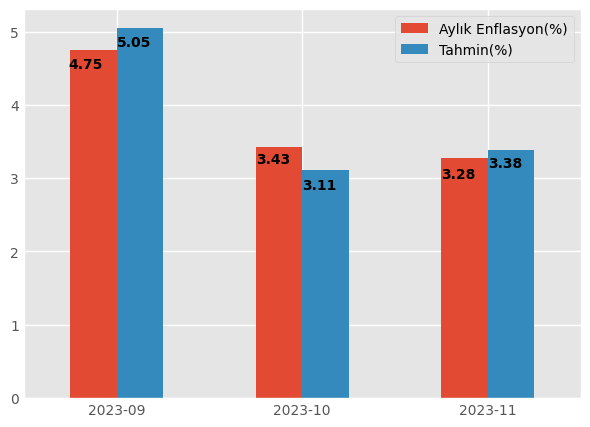

In [183]:
import matplotlib.axes as ax
gecmis=pd.DataFrame({"Aylık Enflasyon(%)":[4.75,3.43,3.28],"Tahmin(%)":[5.05,3.11,3.38]})
gecmis=gecmis.set_index(pd.date_range(start="2023-09-30",periods=3,freq="M"))
gecmis=gecmis.set_index(gecmis.index.strftime("%Y-%m"))
gecmis.plot(kind="bar")
plt.annotate("4.75",xy=(-0.26,4.5),fontweight="bold")
plt.annotate("5.05",xy=(0,4.8),fontweight="bold")
plt.annotate("3.43",xy=(0.75,3.2),fontweight="bold")
plt.annotate("3.11",xy=(1,2.85),fontweight="bold")
plt.annotate("3.28",xy=(1.75,3),fontweight="bold")
plt.annotate("3.38",xy=(2,3.15),fontweight="bold")
plt.legend()
plt.xticks(rotation=0)

In [184]:
aralık=aylıktahmin.iloc[0,-1]
aralık = "{:.2f}".format(aralık)
sonu2023=yıllıktahmin.loc["2023-12-31","Ortalama"]
sonu2023="{:.2f}".format(sonu2023)
sonu2024=yıllıktahmin.loc["2024-12-31","Ortalama"]
sonu2024="{:.2f}".format(sonu2024)


Text(17562.0, 5, 'Değişkenler:USD/TL,Politika Faizi,Mevduat Faizi,TÜFE,Yıllık Enflasyon.')

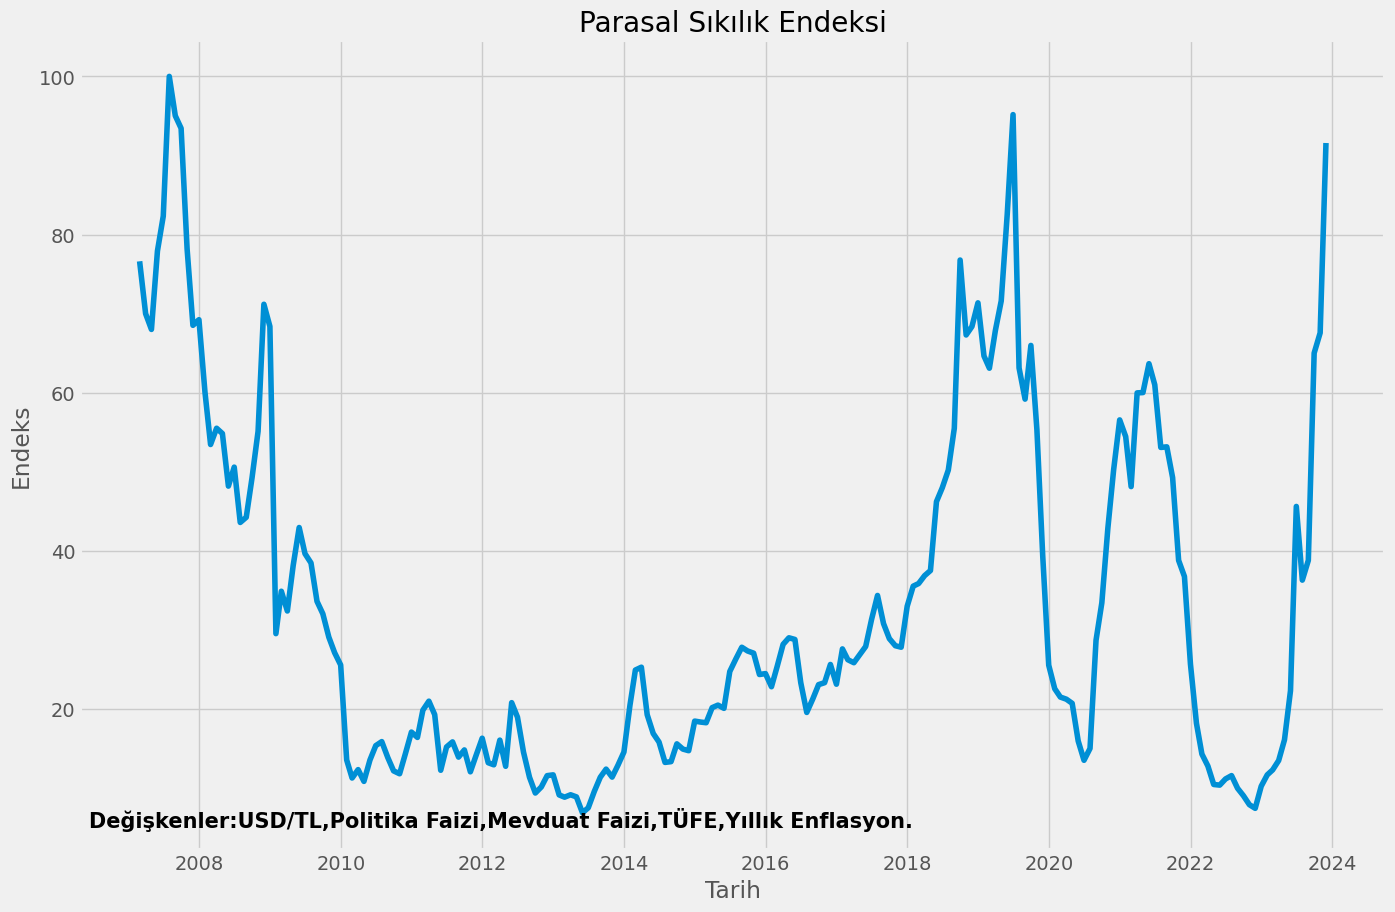

In [185]:
pfaiz.iloc[-1,0]=42.5
endeks=(df6["USD/TL"]*mfaiz["Mevduat Faizi"]*pfaiz["Politika Faizi"])/(df["CPI"]*df["Enflasyon"])
endeks=endeks*(100/endeks.max())
plt.style.use('fivethirtyeight')
fig=plt.figure(figsize=(15,10))
plt.plot(endeks)
plt.title("Parasal Sıkılık Endeksi")
plt.xlabel("Tarih")
plt.ylabel("Endeks")
annotation_date = mdates.datestr2num('2018-01')
plt.text(annotation_date, 5, "Değişkenler:USD/TL,Politika Faizi,Mevduat Faizi,TÜFE,Yıllık Enflasyon.", fontsize=15, color='black', horizontalalignment='right',fontweight='bold')




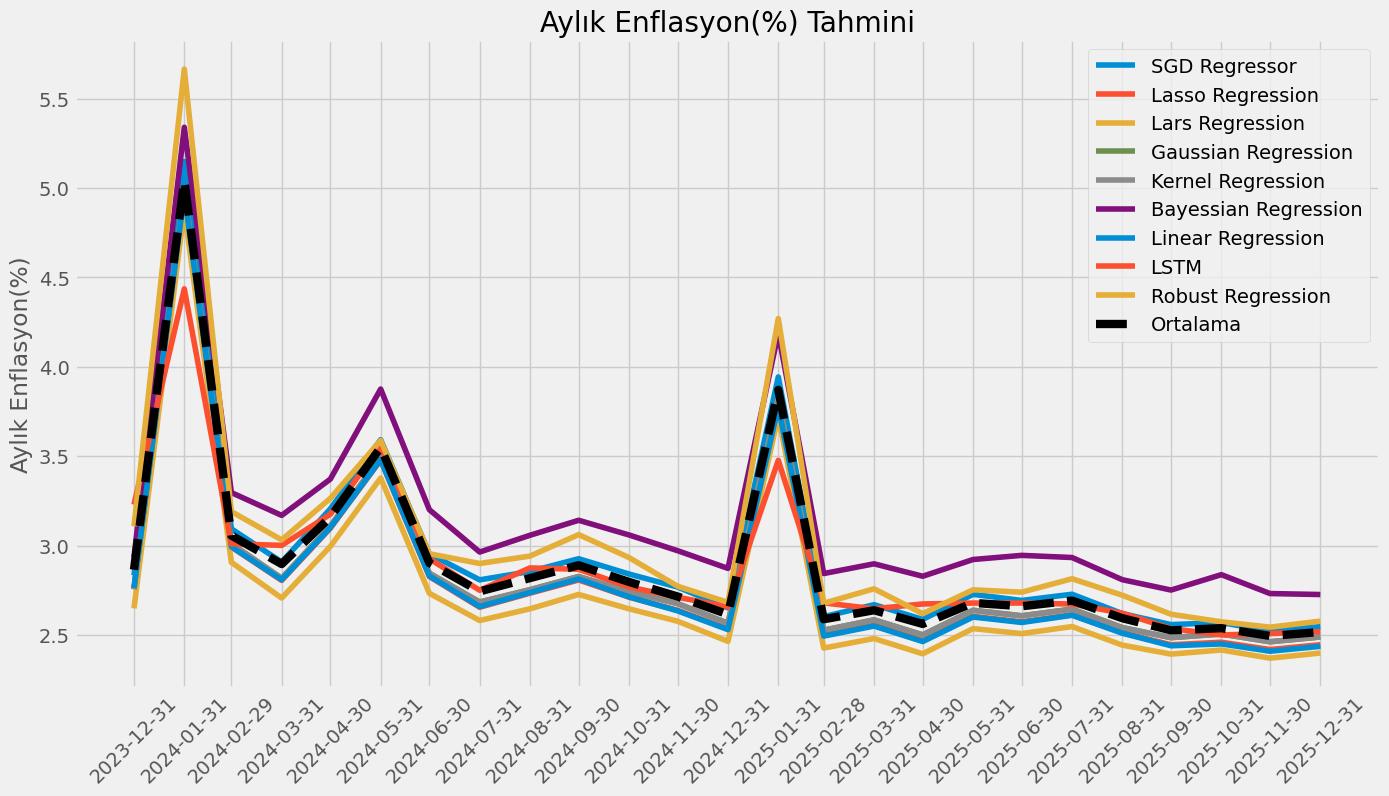

In [186]:
plt.figure(figsize=(15,8))
plt.plot(aylıktahmin.iloc[:-1,:-1],label=aylıktahmin.columns[:-1])
plt.xticks(aylıktahmin.index[:-1],rotation=45)
plt.plot(aylıktahmin["Ortalama"][:-1],"--",label="Ortalama",linewidth=6,color="black")
plt.legend()
plt.title("Aylık Enflasyon(%) Tahmini")
plt.ylabel("Aylık Enflasyon(%)")
plt.show()

In [187]:
'''features=['USD/TL', 'Motorin', 'Perakende Satış', 'Borç', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X=data[features]
y=data[["TÜFE"]]
scalerX = StandardScaler().fit(X)
scalery = StandardScaler().fit(y)
X_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]
X_train = pd.DataFrame(scalerX.transform(X_train),index=X.index[:-3],columns=X.columns)
y_train = pd.DataFrame(scalery.transform(y_train),index=y.index[:-3],columns=y.columns)
X_test = pd.DataFrame(scalerX.transform(X_test),index=X.index[-3:],columns=X.columns)
y_test = pd.DataFrame(scalery.transform(y_test),y.index[-3:],columns=y.columns)
model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT())
results = model.fit()
pred=results.predict(X_test)
pred=np.array(pred).reshape(-1,1)
tahminler["Robust Regression"]=scalery.inverse_transform(pred)
rmse.append(np.sqrt(mean_squared_error(scalery.inverse_transform(y_test),scalery.inverse_transform(pred))))'''

'features=[\'USD/TL\', \'Motorin\', \'Perakende Satış\', \'Borç\', \'Kredi\', \'Mevduat Faizi\', \'REDK\', \'REDKT\', \'İşsizlik\', \'Politika Faizi\']\nX=data[features]\ny=data[["TÜFE"]]\nscalerX = StandardScaler().fit(X)\nscalery = StandardScaler().fit(y)\nX_train,X_test,y_train,y_test=X.iloc[:-3,:],X.iloc[-3:,:],y.iloc[:-3,:],y.iloc[-3:,:]\nX_train = pd.DataFrame(scalerX.transform(X_train),index=X.index[:-3],columns=X.columns)\ny_train = pd.DataFrame(scalery.transform(y_train),index=y.index[:-3],columns=y.columns)\nX_test = pd.DataFrame(scalerX.transform(X_test),index=X.index[-3:],columns=X.columns)\ny_test = pd.DataFrame(scalery.transform(y_test),y.index[-3:],columns=y.columns)\nmodel = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT())\nresults = model.fit()\npred=results.predict(X_test)\npred=np.array(pred).reshape(-1,1)\ntahminler["Robust Regression"]=scalery.inverse_transform(pred)\nrmse.append(np.sqrt(mean_squared_error(scalery.inverse_transform(y_test),scalery.inverse_trans

In [188]:
'''import numpy as np
import pandas as pd
from arch import arch_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
warnings.filterwarnings("ignore")
# Parametreler
param = {"vol":["GARCH","ARCH"],
         "mean":['Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX','constant', 'zero'],
         "lags":[0,1,2,3,6,9,12],
         "p":[1,2,3],
         "q":[1,2,3],
         "dist":['normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error']}

best_rmse = float('inf')  # En iyi RMSE değerini başlangıçta sonsuz olarak ayarla
best_params = None

# En iyi parametreleri bulma
for vol in param["vol"]:
    for mean in param["mean"]:
        for lag in param["lags"]:
            for p_value in param["p"]:
                for q_value in param["q"]:
                        for dist in param["dist"]:
                                # ARCH modelini kurma
                                model = arch_model(data['TÜFE'], vol=vol, mean=mean, lags=lag, p=p_value, q=q_value, dist=dist)
                                result = model.fit(disp='off',show_warning=False)

                                # Tahminler ve RMSE hesaplama
                                volatility = result.conditional_volatility
                                data["Volatility"] = volatility
                                features = ['Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'REDKT', 'Volatility']
                                X = data[features]
                                y = data[["TÜFE"]]
                                X=X.dropna()
                                y=y.loc[X.index]
                                X_train, X_test, y_train, y_test = X.iloc[:-3, :], X.iloc[-3:, :], y.iloc[:-3, :], y.iloc[-3:, :]
                                model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT()).fit()
                                pred = model.predict(X_test)
                                current_rmse = np.sqrt(mean_squared_error(y_test, pred))

                                # En iyi RMSE değerini güncelle
                                if current_rmse < best_rmse:
                                    best_rmse = current_rmse
                                    best_params = {"vol": vol, "mean": mean, "lags": lag, "p": p_value, "q": q_value, "dist": dist}



# En iyi parametreleri yazdır
print("En iyi parametreler:", best_params)
print("En iyi RMSE değeri:", best_rmse)'''


'import numpy as np\nimport pandas as pd\nfrom arch import arch_model\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.metrics import mean_squared_error\nfrom math import sqrt\nwarnings.filterwarnings("ignore")\n# Parametreler\nparam = {"vol":["GARCH","ARCH"],\n         "mean":[\'Constant\', \'Zero\', \'LS\', \'AR\', \'ARX\', \'HAR\', \'HARX\',\'constant\', \'zero\'],\n         "lags":[0,1,2,3,6,9,12],\n         "p":[1,2,3],\n         "q":[1,2,3],\n         "dist":[\'normal\', \'gaussian\', \'t\', \'studentst\', \'skewstudent\', \'skewt\', \'ged\', \'generalized error\']}\n\nbest_rmse = float(\'inf\')  # En iyi RMSE değerini başlangıçta sonsuz olarak ayarla\nbest_params = None\n\n# En iyi parametreleri bulma\nfor vol in param["vol"]:\n    for mean in param["mean"]:\n        for lag in param["lags"]:\n            for p_value in param["p"]:\n                for q_value in param["q"]:\n                        for dist in param["dist"]:\n                                # AR

In [189]:
"""model = arch_model(data['TÜFE'], vol="GARCH", mean='HAR',  p=1, q=3, dist="normal",lags=1)
result = model.fit(disp='off',show_warning=False)
volatility = result.conditional_volatility
data["Volatility"] = volatility
features = ['Motorin', 'Perakende Satış', 'Sanayi', 'Mevduat Faizi', 'REDKT', 'Volatility']
X = data[features]
y=data[["TÜFE"]]
X=X.dropna()
y=y.loc[X.index]
X_train, X_test, y_train, y_test = X.iloc[:-3, :], X.iloc[-3:, :], y.iloc[:-3, :], y.iloc[-3:, :]
model = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT()).fit()
pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))"""

'model = arch_model(data[\'TÜFE\'], vol="GARCH", mean=\'HAR\',  p=1, q=3, dist="normal",lags=1)\nresult = model.fit(disp=\'off\',show_warning=False)\nvolatility = result.conditional_volatility\ndata["Volatility"] = volatility\nfeatures = [\'Motorin\', \'Perakende Satış\', \'Sanayi\', \'Mevduat Faizi\', \'REDKT\', \'Volatility\']\nX = data[features]\ny=data[["TÜFE"]]\nX=X.dropna()\ny=y.loc[X.index]\nX_train, X_test, y_train, y_test = X.iloc[:-3, :], X.iloc[-3:, :], y.iloc[:-3, :], y.iloc[-3:, :]\nmodel = sm.RLM(y_train, X_train, M=sm.robust.norms.HuberT()).fit()\npred = model.predict(X_test)\nnp.sqrt(mean_squared_error(y_test, pred))'